In [1]:
import sys
# if "google.colab" in str(get_ipython()):
! {sys.executable} -m pip install pytorch-lifestream
! {sys.executable} -m pip install catboost
! {sys.executable} -m pip install torchmetrics

In [2]:
from functools import partial
from datetime import timedelta, datetime

import numpy as np
import pandas as pd
import torchmetrics
import matplotlib.pyplot as plt
import seaborn as sns
import catboost

import torch
import pytorch_lightning as pl
from torch.utils.data.dataloader import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split

from ptls.nn import TrxEncoder
from ptls.nn.seq_encoder.rnn_encoder import RnnEncoder
from ptls.frames import PtlsDataModule
from ptls.frames.coles import CoLESModule
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames.coles.multimodal_dataset import MultiModalDataset
from ptls.frames.coles.multimodal_dataset import MultiModalIterableDataset
from ptls.frames.coles.multimodal_dataset import MultiModalSortTimeSeqEncoderContainer
from ptls.frames.coles.multimodal_inference_dataset import MultiModalInferenceDataset
from ptls.frames.coles.multimodal_inference_dataset import MultiModalInferenceIterableDataset
from ptls.frames.inference_module import InferenceModuleMultimodal
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.data_load import IterableProcessingDataset
from ptls.data_load.utils import collate_feature_dict
from ptls.data_load.datasets import MemoryMapDataset
from ptls.preprocessing import PandasDataPreprocessor

In [3]:
# from datasets import load_dataset
import pandas as pd

df = pd.read_csv("hf://datasets/dllllb/rosbank-churn/train.csv.gz")

In [4]:
df

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.00,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.00,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.00,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.00,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.00,C2C_OUT,0,0.0
...,...,...,...,...,...,...,...,...,...,...
490508,01/04/2017,10176,6011,type1,810,24APR17:14:05:26,600.00,WD_ATM_ROS,1,405.0
490509,01/06/2017,10171,5411,type1,810,06JUN17:00:00:00,132.00,POS,0,0.0
490510,01/02/2017,10167,5541,type1,810,03FEB17:00:00:00,1000.00,POS,1,280428.2
490511,01/06/2017,10163,5941,type1,810,08JUN17:00:00:00,100.00,POS,0,0.0


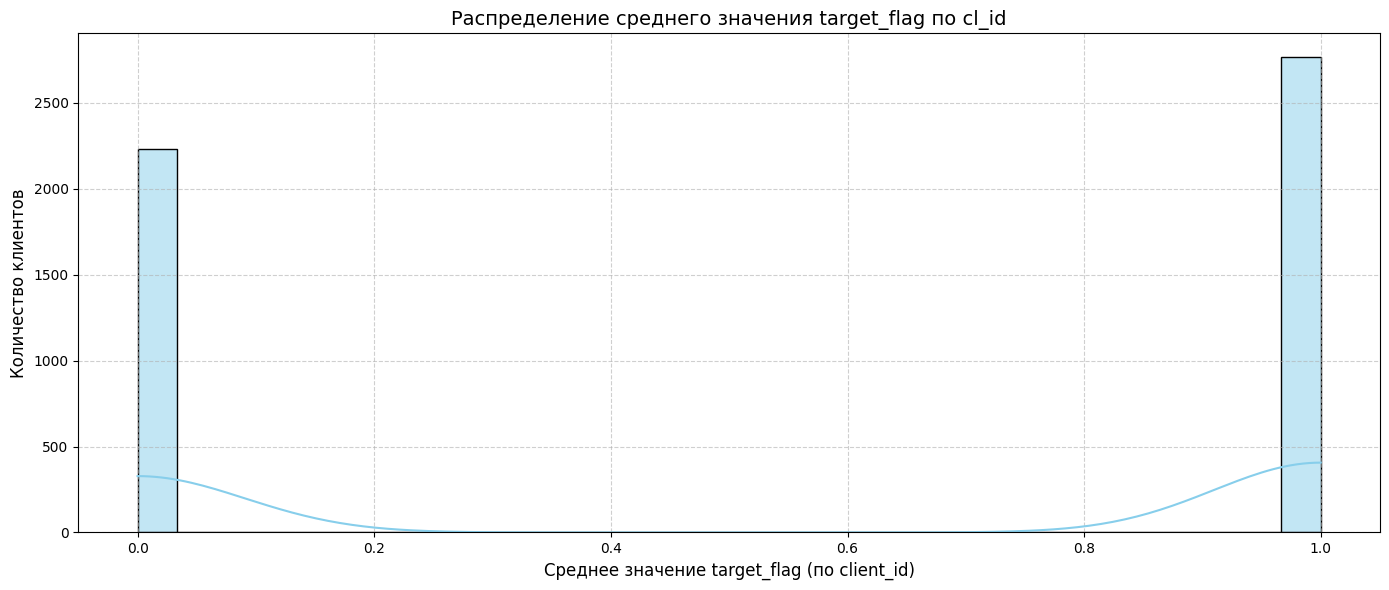

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

cl_target_dist = df.groupby("cl_id")["target_flag"].mean().sort_values()

plt.figure(figsize=(14, 6))
sns.histplot(cl_target_dist, bins=30, kde=True, color='skyblue', edgecolor='black')

plt.title("Распределение среднего значения target_flag по cl_id", fontsize=14)
plt.xlabel("Среднее значение target_flag (по client_id)", fontsize=12)
plt.ylabel("Количество клиентов", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Распределение target_flag по всем событиям')

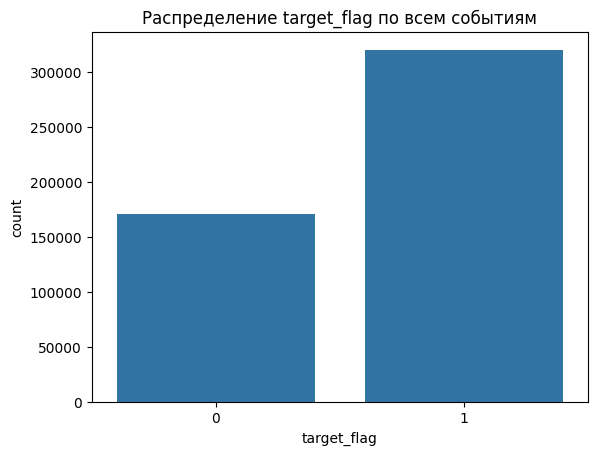

In [6]:
sns.countplot(data=df, x="target_flag")
plt.title("Распределение target_flag по всем событиям")


In [7]:
for col in ["MCC", "channel_type", "currency", "trx_category"]:
    print(f"{col}: {df[f'{col}'].explode().nunique()} уникальных значений")


MCC: 344 уникальных значений
channel_type: 5 уникальных значений
currency: 59 уникальных значений
trx_category: 10 уникальных значений


In [8]:
mcc_flag = df[["MCC", "cl_id", "target_flag"]]
mcc_flag = mcc_flag.groupby("cl_id").agg({"MCC": lambda x: list(x), "target_flag": "mean"})
mcc_flag["target_flag_bin"] = (mcc_flag["target_flag"] > 0.5).astype(int)

from collections import Counter
from itertools import chain

for flag in [0, 1]:
    all_mccs = list(chain.from_iterable(mcc_flag[mcc_flag["target_flag_bin"] == flag]["MCC"]))
    most_common = Counter(all_mccs).most_common(10)
    print(f"\nTop MCC codes for target_flag={flag}:")
    for mcc, count in most_common:
        print(f"  MCC: {mcc}, count: {count}")



Top MCC codes for target_flag=0:
  MCC: 5411, count: 46297
  MCC: 6011, count: 18858
  MCC: 5814, count: 11066
  MCC: 5499, count: 9324
  MCC: 5812, count: 8286
  MCC: 5541, count: 7200
  MCC: 5912, count: 6752
  MCC: 6012, count: 4347
  MCC: 5999, count: 3902
  MCC: 5921, count: 2808

Top MCC codes for target_flag=1:
  MCC: 5411, count: 75343
  MCC: 6011, count: 35524
  MCC: 5814, count: 30285
  MCC: 5812, count: 21741
  MCC: 5499, count: 17913
  MCC: 5541, count: 12616
  MCC: 5912, count: 11976
  MCC: 5999, count: 9171
  MCC: 5921, count: 5770
  MCC: 6012, count: 5709


In [9]:
print(df["target_flag"].value_counts(normalize=True))


target_flag
1    0.652588
0    0.347412
Name: proportion, dtype: float64


In [10]:
df['PERIOD']

0         01/10/2017
1         01/10/2017
2         01/12/2017
3         01/10/2017
4         01/10/2017
             ...    
490508    01/04/2017
490509    01/06/2017
490510    01/02/2017
490511    01/06/2017
490512    01/06/2017
Name: PERIOD, Length: 490513, dtype: object

In [11]:
for col in df.columns:
    print(col, df[col].isna().sum())

PERIOD 0
cl_id 0
MCC 0
channel_type 2910
currency 0
TRDATETIME 0
amount 0
trx_category 0
target_flag 0
target_sum 0


In [12]:
df = df.dropna().reset_index(drop=True)

In [13]:
n_cutomers = len(pd.unique(df["cl_id"]))

print("n_cutomers:", n_cutomers)

n_cutomers: 4975


In [14]:
for col in df.columns:
    print(col, df[col].isna().sum())

PERIOD 0
cl_id 0
MCC 0
channel_type 0
currency 0
TRDATETIME 0
amount 0
trx_category 0
target_flag 0
target_sum 0


In [15]:
df["period_ym"] = pd.to_datetime(df["PERIOD"], format="%d/%m/%Y").dt.strftime("%Y%m")

In [16]:
sourceA_columns = ["cl_id", "TRDATETIME", "MCC", "channel_type", "currency", "trx_category"]
sourceB_columns = ["cl_id", "TRDATETIME", "amount", "period_ym"]

sourceA = df[sourceA_columns].copy()
sourceB = df[sourceB_columns].copy()

In [17]:
sourceA

,cl_id,TRDATETIME,MCC,channel_type,currency,trx_category
0,50,14JUL17:06:53:13,4829,type5,810,C2C_IN
1,50,15SEP17:00:00:00,5411,type5,810,POS
2,50,24SEP17:00:00:00,5812,type5,810,POS
3,50,08JUL17:00:00:00,5661,type5,810,POS
4,50,08JUL17:00:00:00,5732,type5,810,POS
...,...,...,...,...,...,...
487598,10176,24APR17:14:05:26,6011,type1,810,WD_ATM_ROS
487599,10171,06JUN17:00:00:00,5411,type1,810,POS
487600,10167,03FEB17:00:00:00,5541,type1,810,POS
487601,10163,08JUN17:00:00:00,5941,type1,810,POS


In [18]:
sourceB

,cl_id,TRDATETIME,amount,period_ym
0,50,14JUL17:06:53:13,40000.00,201707
1,50,15SEP17:00:00:00,2373.00,201709
2,50,24SEP17:00:00:00,5955.00,201709
3,50,08JUL17:00:00:00,5599.00,201707
4,50,08JUL17:00:00:00,29600.00,201707
...,...,...,...,...
487598,10176,24APR17:14:05:26,600.00,201704
487599,10171,06JUN17:00:00:00,132.00,201706
487600,10167,03FEB17:00:00:00,1000.00,201702
487601,10163,08JUN17:00:00:00,100.00,201706


In [19]:
sourceA_drop_indices = np.random.choice(sourceA.index, int(130000/4084151 * len(sourceA)), replace=False)
sourceB_drop_indices = np.random.choice(sourceB.index, int(420000/4084151 * len(sourceB)), replace=False)

sourceA = sourceA.drop(sourceA_drop_indices).reset_index(drop=True)
sourceB = sourceB.drop(sourceB_drop_indices).reset_index(drop=True)

In [20]:
sourceA

,cl_id,TRDATETIME,MCC,channel_type,currency,trx_category
0,50,14JUL17:06:53:13,4829,type5,810,C2C_IN
1,50,15SEP17:00:00:00,5411,type5,810,POS
2,50,24SEP17:00:00:00,5812,type5,810,POS
3,50,08JUL17:00:00:00,5661,type5,810,POS
4,50,08JUL17:00:00:00,5732,type5,810,POS
...,...,...,...,...,...,...
472078,10176,24APR17:14:05:26,6011,type1,810,WD_ATM_ROS
472079,10171,06JUN17:00:00:00,5411,type1,810,POS
472080,10167,03FEB17:00:00:00,5541,type1,810,POS
472081,10163,08JUN17:00:00:00,5941,type1,810,POS


In [21]:
def tr_datetime_preprocess(tr_datetime):
    dt = datetime.strptime(tr_datetime, "%d%b%y:%H:%M:%S")

    timestamp_seconds = int(dt.timestamp())
    return timestamp_seconds

In [22]:
sourceA["TRDATETIME"] = sourceA["TRDATETIME"].apply(tr_datetime_preprocess)
sourceB["TRDATETIME"] = sourceB["TRDATETIME"].apply(tr_datetime_preprocess)

In [23]:
sourceB['period_ym'] = sourceB['period_ym'].astype(int)

In [24]:
sourceA_preprocessor = PandasDataPreprocessor(
    col_id="cl_id",
    col_event_time="TRDATETIME",
    event_time_transformation="none",
    cols_category=["MCC", "channel_type", "currency", "trx_category"],
    return_records=False,
)

sourceB_preprocessor = PandasDataPreprocessor(
    col_id="cl_id",
    col_event_time="TRDATETIME",
    event_time_transformation="none",
    cols_numerical=["period_ym", "amount"],
    return_records=False,
)

In [25]:
processed_sourceA = sourceA_preprocessor.fit_transform(sourceA)
processed_sourceB = sourceB_preprocessor.fit_transform(sourceB)

In [26]:
processed_sourceA.columns = [
    "sourceA_" + str(col) if str(col) != "cl_id" else str(col)
    for col in processed_sourceA.columns
]

In [27]:
processed_sourceB.columns = [
    "sourceB_" + str(col) if str(col) != "cl_id" else str(col)
    for col in processed_sourceB.columns
]

In [28]:
processed_sourceB

,cl_id,sourceB_TRDATETIME,sourceB_event_time,sourceB_period_ym,sourceB_amount
0,50,"[tensor(1499461200), tensor(1499461200), tenso...","[tensor(1499461200), tensor(1499461200), tenso...","[tensor(201707), tensor(201707), tensor(201707...","[tensor(29600., dtype=torch.float64), tensor(1..."
1,52,"[tensor(1500411600), tensor(1500584400), tenso...","[tensor(1500411600), tensor(1500584400), tenso...","[tensor(201707), tensor(201707), tensor(201707...","[tensor(27000., dtype=torch.float64), tensor(2..."
2,54,"[tensor(1491858000), tensor(1491858000), tenso...","[tensor(1491858000), tensor(1491858000), tenso...","[tensor(201704), tensor(201704), tensor(201704...","[tensor(133.8200, dtype=torch.float64), tensor..."
3,55,"[tensor(1486328400), tensor(1486414800), tenso...","[tensor(1486328400), tensor(1486414800), tenso...","[tensor(201702), tensor(201702), tensor(201702...","[tensor(209., dtype=torch.float64), tensor(112..."
4,56,"[tensor(1484539537), tensor(1485329683), tenso...","[tensor(1484539537), tensor(1485329683), tenso...","[tensor(201701), tensor(201701), tensor(201702...","[tensor(5000., dtype=torch.float64), tensor(50..."
...,...,...,...,...,...
4965,10210,"[tensor(1476910800), tensor(1477429200), tenso...","[tensor(1476910800), tensor(1477429200), tenso...","[tensor(201610), tensor(201610), tensor(201610...","[tensor(744., dtype=torch.float64), tensor(568..."
4966,10212,"[tensor(1494795600), tensor(1497348827), tenso...","[tensor(1494795600), tensor(1497348827), tenso...","[tensor(201705), tensor(201706), tensor(201706...","[tensor(26000., dtype=torch.float64), tensor(5..."
4967,10213,"[tensor(1491930246), tensor(1491944400), tenso...","[tensor(1491930246), tensor(1491944400), tenso...","[tensor(201704), tensor(201704), tensor(201704...","[tensor(40000., dtype=torch.float64), tensor(6..."
4968,10214,"[tensor(1479330000), tensor(1479416400), tenso...","[tensor(1479330000), tensor(1479416400), tenso...","[tensor(201611), tensor(201611), tensor(201611...","[tensor(671., dtype=torch.float64), tensor(120..."


In [29]:
for col in processed_sourceB.columns:
    print(col, processed_sourceB[col].isna().sum())

cl_id 0
sourceB_TRDATETIME 0
sourceB_event_time 0
sourceB_period_ym 0
sourceB_amount 0


In [30]:
joined_data = processed_sourceA.merge(processed_sourceB, how="outer", on="cl_id")

In [31]:
joined_data

,cl_id,sourceA_TRDATETIME,sourceA_event_time,sourceA_MCC,sourceA_channel_type,sourceA_currency,sourceA_trx_category,sourceB_TRDATETIME,sourceB_event_time,sourceB_period_ym,sourceB_amount
0,50,"[tensor(1499461200), tensor(1499461200), tenso...","[tensor(1499461200), tensor(1499461200), tenso...","[tensor(30), tensor(20), tensor(23), tensor(30...","[tensor(3), tensor(3), tensor(3), tensor(3), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1499461200), tensor(1499461200), tenso...","[tensor(1499461200), tensor(1499461200), tenso...","[tensor(201707), tensor(201707), tensor(201707...","[tensor(29600., dtype=torch.float64), tensor(1..."
1,52,"[tensor(1500411600), tensor(1500584400), tenso...","[tensor(1500411600), tensor(1500584400), tenso...","[tensor(81), tensor(81), tensor(1), tensor(1),...","[tensor(3), tensor(3), tensor(3), tensor(3), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1500411600), tensor(1500584400), tenso...","[tensor(1500411600), tensor(1500584400), tenso...","[tensor(201707), tensor(201707), tensor(201707...","[tensor(27000., dtype=torch.float64), tensor(2..."
2,54,"[tensor(1491858000), tensor(1491858000), tenso...","[tensor(1491858000), tensor(1491858000), tenso...","[tensor(1), tensor(3), tensor(25), tensor(22),...","[tensor(3), tensor(3), tensor(3), tensor(3), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(8), t...","[tensor(1491858000), tensor(1491858000), tenso...","[tensor(1491858000), tensor(1491858000), tenso...","[tensor(201704), tensor(201704), tensor(201704...","[tensor(133.8200, dtype=torch.float64), tensor..."
3,55,"[tensor(1486328400), tensor(1486414800), tenso...","[tensor(1486328400), tensor(1486414800), tenso...","[tensor(1), tensor(65), tensor(1), tensor(1), ...","[tensor(3), tensor(3), tensor(3), tensor(3), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1486328400), tensor(1486414800), tenso...","[tensor(1486328400), tensor(1486414800), tenso...","[tensor(201702), tensor(201702), tensor(201702...","[tensor(209., dtype=torch.float64), tensor(112..."
4,56,"[tensor(1484539537), tensor(1485329683), tenso...","[tensor(1484539537), tensor(1485329683), tenso...","[tensor(2), tensor(2), tensor(2), tensor(2), t...","[tensor(3), tensor(3), tensor(3), tensor(3), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(3), tensor(3), tensor(3), tensor(3), t...","[tensor(1484539537), tensor(1485329683), tenso...","[tensor(1484539537), tensor(1485329683), tenso...","[tensor(201701), tensor(201701), tensor(201702...","[tensor(5000., dtype=torch.float64), tensor(50..."
...,...,...,...,...,...,...,...,...,...,...,...
4970,10210,"[tensor(1476910800), tensor(1477429200), tenso...","[tensor(1476910800), tensor(1477429200), tenso...","[tensor(3), tensor(1), tensor(3), tensor(19), ...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1476910800), tensor(1477429200), tenso...","[tensor(1476910800), tensor(1477429200), tenso...","[tensor(201610), tensor(201610), tensor(201610...","[tensor(744., dtype=torch.float64), tensor(568..."
4971,10212,"[tensor(1494363600), tensor(1494795600), tenso...","[tensor(1494363600), tensor(1494795600), tenso...","[tensor(33), tensor(33), tensor(33), tensor(2)...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(1), tensor(1), tensor(1), tensor(2), t...","[tensor(1494795600), tensor(1497348827), tenso...","[tensor(1494795600), tensor(1497348827), tenso...","[tensor(201705), tensor(201706), tensor(201706...","[tensor(26000., dtype=torch.float64), tensor(5..."
4972,10213,"[tensor(1491930246), tensor(1491944400), tenso...","[tensor(149193

In [32]:
joined_data = joined_data.map(lambda x: torch.tensor([]) if pd.isna(x) else x)

In [33]:
all_clients = joined_data["cl_id"].unique()

clients_train_val, clients_test = train_test_split(all_clients, test_size=0.2, random_state=42)

clients_train, clients_valid = train_test_split(clients_train_val, test_size=0.1, random_state=42)

train_df = joined_data[joined_data["cl_id"].isin(clients_train)].reset_index(drop=True)
valid_df = joined_data[joined_data["cl_id"].isin(clients_valid)].reset_index(drop=True)
test_df  = joined_data[joined_data["cl_id"].isin(clients_test)].reset_index(drop=True)

train_dict = train_df.to_dict("records")
valid_dict = valid_df.to_dict("records")
test_dict  = test_df.to_dict("records")

In [34]:
source_features = {
    "sourceA": {
        "categorical": ["MCC", "channel_type", "currency", "trx_category"],
        "numeric": [],
    },
    "sourceB": {
        "categorical": [],
        "numeric": ["amount", "period_ym"],
    },
}

inf_test_data = MultiModalInferenceIterableDataset(
    data=test_dict,
    source_features=source_features,
    col_id="cl_id",
    col_time="TRDATETIME",
    source_names=("sourceA", "sourceB"),
)


In [35]:
inf_test_loader = DataLoader(
    dataset = inf_test_data,
    collate_fn = partial(inf_test_data.collate_fn, col_id="cl_id"),
    shuffle = False,
    num_workers = 0,
    batch_size = 8
)

In [36]:
inf_train_data = MultiModalInferenceIterableDataset(
    data=train_dict,
    source_features=source_features,
    col_id="cl_id",
    col_time="TRDATETIME",
    source_names=("sourceA", "sourceB"),
)


inf_train_loader = DataLoader(
    dataset = inf_train_data,
    collate_fn = partial(inf_train_data.collate_fn, col_id="cl_id"),
    shuffle = False,
    num_workers = 0,
    batch_size = 8
)

In [37]:
!git clone https://github.com/google-research/google-research.git

fatal: destination path 'google-research' already exists and is not an empty directory.


In [38]:
!ls google-research/graph_embedding/metrics

README.md  __pycache__	example.py  metrics.py


In [39]:
import sys
sys.path.append("google-research/graph_embedding/metrics")

In [40]:
from metrics import (rankme,
        coherence,
        pseudo_condition_number,
        alpha_req,
        stable_rank,
        ne_sum,
        self_clustering)

In [41]:
!pip install git+https://github.com/simonzhang00/ripser-plusplus.git

  Cloning https://github.com/simonzhang00/ripser-plusplus.git to /tmp/pip-req-build-6pypqbzw
  Running command git clone --filter=blob:none --quiet https://github.com/simonzhang00/ripser-plusplus.git /tmp/pip-req-build-6pypqbzw
  Resolved https://github.com/simonzhang00/ripser-plusplus.git to commit 30243c0c752de26d7fdf6e41f08bf7b840ca4744
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [42]:
import ripserplusplus as rpp
from time import time
def ripser_metric(embeddings, u=None, s=None):
    
    diagrams = rpp.run("--format point-cloud", embeddings)
    persistence = {}

    for k in range(len(diagrams)):
        persistence_sum = sum([death - birth for birth, death in diagrams[k] if death > birth])
        persistence[f"ripser_sum_H{k}"] = persistence_sum

    return persistence

In [43]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [44]:
def create_datasets(train_dict, valid_dict, params, source_features):
    splitter = SampleSlices(
        split_count=params["split_count"],
        cnt_min=params["cnt_min"],
        cnt_max=params["cnt_max"],
    )

    train_data = MultiModalIterableDataset(
        data=train_dict,
        splitter=splitter,
        source_features=source_features,
        col_id="cl_id",
        col_time="TRDATETIME",
        source_names=("sourceA", "sourceB"),
    )

    valid_data = MultiModalIterableDataset(
        data=valid_dict,
        splitter=splitter,
        source_features=source_features,
        col_id="cl_id",
        col_time="TRDATETIME",
        source_names=("sourceA", "sourceB"),
    )

    data_loader = PtlsDataModule(
        train_data=train_data,
        train_batch_size=params["batch_size"],
        train_num_workers=0,
        valid_data=valid_data,
    )

    return data_loader

In [45]:
import logging
import os

os.makedirs('logs/rosbank', exist_ok=True)

logger = logging.getLogger("my_logger")
logger.setLevel(logging.INFO)

file_handler = logging.FileHandler("logs/rosbank/fraction_experiment.log")
formatter = logging.Formatter('%(asctime)s [%(levelname)s] %(message)s')
file_handler.setFormatter(formatter)

# Удалим другие обработчики
if logger.hasHandlers():
    logger.handlers.clear()

logger.addHandler(file_handler)
logger.info("🔧 Логгер настроен вручную")

In [46]:
def compute_metrics(model, pl_trainer, inf_test_loader, selected_metrics=None, n_samples=10, sample_fraction=1/20):
    import gc
    from sklearn.utils import resample
    from time import time
    
    logger.info(f'{sample_fraction=}')

    model.eval()
    inference_module = InferenceModuleMultimodal(
        model=model,
        pandas_output=True,
        drop_seq_features=True,
        model_out_name="emb",
        col_id="cl_id",
    )
    inference_module.model.is_reduce_sequence = True

    # Получение эмбеддингов
    inf_test_embeddings = pd.concat(
        pl_trainer.predict(inference_module, inf_test_loader),
        axis=0,
    )
    embeddings_np = inf_test_embeddings.drop(columns=["cl_id"]).to_numpy(dtype=np.float32)
    sample_size = max(1, int(sample_fraction * embeddings_np.shape[0]))

    # Метрики
    available_metrics = {
        "rankme": rankme,
        "coherence": coherence,
        "pseudo_condition_number": pseudo_condition_number,
        "alpha_req": alpha_req,
        "stable_rank": stable_rank,
        "ne_sum": ne_sum,
        "self_clustering": self_clustering,
        "ripser": ripser_metric
    }
    if selected_metrics is None:
        selected_metrics = list(available_metrics.keys())

    metrics = {name: [] for name in selected_metrics}
    times = {name: [] for name in selected_metrics}

    for i in range(n_samples):
        sample = resample(embeddings_np, n_samples=sample_size, replace=False, random_state=42 + i)
        u, s, _ = np.linalg.svd(sample, compute_uv=True, full_matrices=False)

        for metric_name in selected_metrics:
            if metric_name not in available_metrics:
                continue

            try:
                t0 = time()
                result = available_metrics[metric_name](sample, u=u, s=s)
                t = time() - t0

                if isinstance(result, dict):
                    for subname, val in result.items():
                        if subname not in metrics:
                            metrics[subname] = []
                            times[subname] = []
                        metrics[subname].append(val)
                        times[subname].append(t)
                else:
                    if metric_name not in metrics:
                        metrics[metric_name] = []
                        times[metric_name] = []
                    metrics[metric_name].append(result)
                    times[metric_name].append(t)
            except Exception as e:
                print(f"⚠️ Failed to compute {metric_name} on sample {i}: {e}")

        gc.collect()

    averaged_metrics = {k: np.mean(v) for k, v in metrics.items()}
    std_metrics = {k: np.std(v) for k, v in metrics.items()}
    
    averaged_times = {k: np.mean(v) for k, v in times.items()}
    std_times = {k: np.std(v) for k, v in times.items()}

    print("\n📊 Средние значения метрик и время вычисления:")
    for metric_name in averaged_metrics:
        metric_value = averaged_metrics[metric_name]
        metric_time = averaged_times.get(metric_name, None)
        print(f"🧠 {metric_name:30s} = {metric_value:.4f} | ⏱ {metric_time:.4f} сек")

    return averaged_metrics, averaged_times, inf_test_embeddings

In [47]:
targets_df = df.groupby('cl_id')['target_flag'].mean().reset_index()
targets_df['target_flag'] = (targets_df['target_flag'] > 0.5).astype(int)

In [48]:
targets_df

,cl_id,target_flag
0,50,1
1,52,0
2,54,0
3,55,0
4,56,1
...,...,...
4970,10210,1
4971,10212,0
4972,10213,0
4973,10214,0


In [49]:
from time import time
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

def evaluate_model(model, pl_trainer, selected_metrics=None, sample_fraction=1/20):
    model.eval()

    metrics, times, inf_train_embeddings = compute_metrics(model, pl_trainer, inf_train_loader, selected_metrics, sample_fraction=sample_fraction)

    inf_train_df = inf_train_embeddings.merge(targets_df, how="inner", on="cl_id").set_index("cl_id")

    X = inf_train_df.drop(columns=["target_flag"])
    y = inf_train_df["target_flag"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    cur_time = time()
    classifier = CatBoostClassifier(
        iterations=150,
        random_seed=42,
        verbose=0,
    )
    classifier.fit(X_train, y_train)
    accuracy = classifier.score(X_test, y_test)

    print(f'{accuracy=} in {time() - cur_time} seconds')

    del classifier

    return metrics, times, accuracy

In [50]:
metric_names = [
    "rankme", "coherence", "pseudo_condition_number",
    "alpha_req", "stable_rank", "ne_sum", "self_clustering", "ripser"
]

In [51]:
fixed_params = {
    "batch_size": 64,
    "learning_rate": 0.001,
    "split_count": 3,
    "cnt_min": 10,
    "cnt_max": 50,
    "embedding_dim": 16,  # Размерность эмбеддингов
    "category_embedding_dim": 8,  # Размерность категорий эмбеддингов
    "hidden_size": 128,  # Размер скрытого слоя по умолчанию
}

variable_params = {
    "batch_size": [16, 32, 64, 128],
    "learning_rate": [0.0001, 0.001, 0.05],
    "split_count": [2, 3, 5],
    "cnt_min": [5, 10, 20],
    "cnt_max": [50, 80, 100],
    "embedding_dim": [8, 16, 32],
    "category_embedding_dim": [8, 16, 24],
    "hidden_size": [64, 128, 256],
}

all_hyperparameter_grids = []
for variable_param_name, variable_param_values in variable_params.items():
    for value in variable_param_values:
        hyperparameter_grid = {**fixed_params, variable_param_name: value}
        all_hyperparameter_grids.append((variable_param_name, hyperparameter_grid))


In [52]:
category_embedding_dims = {
    "MCC": (df["MCC"].nunique(), fixed_params["category_embedding_dim"]),
    "channel_type": (df["channel_type"].nunique(), fixed_params["category_embedding_dim"]),
    "currency": (df["currency"].nunique(), fixed_params["category_embedding_dim"]),
    "trx_category": (df["trx_category"].nunique(), fixed_params["category_embedding_dim"]),
}

In [53]:
import os

checkpoints_path = "rosbank/checkpoints"
os.makedirs(checkpoints_path, exist_ok=True)

In [54]:
splitter = SampleSlices(split_count=fixed_params['split_count'], cnt_min=fixed_params['cnt_min'], cnt_max=fixed_params['cnt_max'])

In [55]:
class CustomLogger(pl.Callback):
    def __init__(self):
        super().__init__()
        self.early_stopping_epoch = None
    
    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get("train_loss", None)
        val_loss = trainer.callback_metrics.get("val_loss", None)
        
        if train_loss is not None and val_loss is not None:
            print(f"Epoch {trainer.current_epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if trainer.early_stopping_callback is not None and trainer.early_stopping_callback.wait_count == 0:
            self.early_stopping_epoch = trainer.current_epoch


custom_logger = CustomLogger()
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    verbose=True
)

In [56]:
! rm -rf checkpoints

In [57]:
num_epochs = 30
# output_csv = "rosbank_ripser_h1h2.csv"


columns = [
    *fixed_params.keys(), "checkpoint", "epoch_num", "accuracy", "early_stop_epoch", "hidden_size",
] + [
    "metric_" + key for key in [
        "rankme", "coherence", "pseudo_condition_number", 
        "alpha_req", "stable_rank", "ne_sum", "self_clustering", "ripser_sum_H0", "ripser_sum_H1"
    ]
] + ["time_" + key for key in [
    "rankme", "coherence", "pseudo_condition_number", 
    "alpha_req", "stable_rank", "ne_sum", "self_clustering", "ripser_sum_H0", "ripser_sum_H1"
]]

In [58]:
import os
import gc
import torch
import pandas as pd
import glob
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from functools import partial

In [ ]:
cur_time = time()
for sample_fraction in np.linspace(1/20, 1, 5):
    print(f"{sample_fraction:.2f}")
    logger.info(f"{sample_fraction=:.2f}")
    output_csv = f"csv_results/rosbank_sample_fraction_{sample_fraction:.3f}".rstrip('0').rstrip('.') + ".csv"
    for param in all_hyperparameter_grids:
        logger.info(f'All params are frozen except {param[0]}')
        params = param[1]
        logger.info(f"Testing parameters: {params}")

        train_loader = create_datasets(train_dict, valid_dict, params, source_features)

        sourceA_encoder_params = dict(
            embeddings_noise=0.003,
            linear_projection_size=64,
            embeddings={
                "MCC": {"in": len(np.unique(sourceA['MCC'])), "out": params["category_embedding_dim"]},
                "channel_type": {"in": len(np.unique(sourceA['channel_type'])), "out": params["category_embedding_dim"]},
                "currency": {"in": len(np.unique(sourceA['currency'])), "out": params["category_embedding_dim"]},
                "trx_category": {"in": len(np.unique(sourceA['trx_category'])), "out": params["category_embedding_dim"]},
            },
        )

        sourceB_encoder_params = dict(
            embeddings_noise=0.003,
            linear_projection_size=64,
            numeric_values={"amount": "identity", "period_ym": "identity"},
        )

        sourceA_encoder = TrxEncoder(**sourceA_encoder_params)
        sourceB_encoder = TrxEncoder(**sourceB_encoder_params)

        seq_encoder = MultiModalSortTimeSeqEncoderContainer(
            trx_encoders={"sourceA": sourceA_encoder, "sourceB": sourceB_encoder},
            input_size=64,
            hidden_size=params["hidden_size"],
            seq_encoder_cls=RnnEncoder,
            type="gru",
        )

        model = CoLESModule(
            seq_encoder=seq_encoder,
            optimizer_partial=partial(torch.optim.Adam, lr=params["learning_rate"]),
            lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=10, gamma=0.5),
        )

        early_stopping_callback = EarlyStopping(
            monitor="loss",
            patience=5,
            mode="min",
            verbose=True
        )

        checkpoint_callback = ModelCheckpoint(
            dirpath=checkpoints_path,
            filename=f"model_{params['batch_size']}_{params['learning_rate']}_{params['split_count']}_{params['cnt_min']}_{params['cnt_max']}_{params['hidden_size']}{{epoch:02d}}",
            save_top_k=-1,
            every_n_epochs=1,
        )

        pl_trainer = Trainer(
            callbacks=[checkpoint_callback, early_stopping_callback, custom_logger],
            default_root_dir=checkpoints_path,
            check_val_every_n_epoch=1,
            max_epochs=num_epochs,
            accelerator="gpu",
            devices=1,
            enable_progress_bar=True,
            precision=16
        )

        model.train()
        pl_trainer.fit(model, train_loader)

        early_stop_epoch = getattr(custom_logger, "early_stopping_epoch", None) or num_epochs

        checkpoint_files = glob.glob(
            f"{checkpoints_path}/model_{params['batch_size']}_{params['learning_rate']}_{params['split_count']}_{params['cnt_min']}_{params['cnt_max']}_{params['hidden_size']}*.ckpt"
        )
        checkpoint_files.sort()
        logger.info(f"Elapsed time: {time() - cur_time:.2f} seconds")
        logger.info(f'Early stop is {early_stop_epoch}')

        for i, checkpoint in enumerate(checkpoint_files):
            logger.info(f"Processing checkpoint number {i}")
            model = CoLESModule.load_from_checkpoint(checkpoint, seq_encoder=seq_encoder)

            metrics, times, accuracy = evaluate_model(model, pl_trainer, sample_fraction=sample_fraction)
            metrics_flattened = {f"metric_{k}": round(v, 4) for k, v in metrics.items()}
            times_flattened = {f"time_{k}": round(v, 4) for k, v in times.items()}

            new_result = {
                **params,
                "checkpoint": checkpoint,
                "epoch_num": int(i),
                "accuracy": accuracy,
                **metrics_flattened,
                **times_flattened,
                "early_stop_epoch": int(early_stop_epoch)
            }

            results = pd.DataFrame([new_result], columns=columns)

            if not os.path.exists(output_csv):
                pd.DataFrame(columns=columns).to_csv(output_csv, mode="w", index=False, header=True)

            results.to_csv(output_csv, mode="a", header=False, index=False)

            del metrics, accuracy, new_result
            torch.cuda.empty_cache()
            gc.collect()

        logger.info(f"Removing checkpoints for parameters: {params}")
        for checkpoint in checkpoint_files:
            os.remove(checkpoint)

        del model
        del train_loader
        torch.cuda.empty_cache()
        gc.collect()

    logger.info(f"Optimization for {sample_fraction=} complete!")
logger.info(f"Optimization complete!")

0.05


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly 

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 9.310


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.557 >= min_delta = 0.0. New best score: 7.752


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.246 >= min_delta = 0.0. New best score: 6.506


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.328 >= min_delta = 0.0. New best score: 6.178


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.068 >= min_delta = 0.0. New best score: 6.110


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.956 >= min_delta = 0.0. New best score: 5.154


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.421 >= min_delta = 0.0. New best score: 4.733


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 4.733. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 26.4819 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3872 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1740 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2822 | ⏱ 0.0000 сек
🧠 ne_sum                         = 2.6606 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5922 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 227.5971 | ⏱ 0.0222 сек
🧠 ripser_sum_H1                  = 8.9113 | ⏱ 0.0222 сек
accuracy=np.float64(0.6846511627906977) in 0.47603535652160645 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 29.8015 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3846 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0654 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2905 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.5180 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5951 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 267.1006 | ⏱ 0.0228 сек
🧠 ripser_sum_H1                  = 11.5983 | ⏱ 0.0228 сек
accuracy=np.float64(0.6967441860465117) in 0.39582252502441406 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.1791 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3786 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0844 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2720 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.4847 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6143 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 301.8682 | ⏱ 0.0232 сек
🧠 ripser_sum_H1                  = 14.0180 | ⏱ 0.0232 сек
accuracy=np.float64(0.706046511627907) in 0.39174699783325195 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 31.9723 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3824 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1526 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2058 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.8443 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6776 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 317.4535 | ⏱ 0.0249 сек
🧠 ripser_sum_H1                  = 17.6540 | ⏱ 0.0249 сек
accuracy=np.float64(0.7134883720930233) in 0.39150285720825195 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 34.3944 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3798 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1550 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2218 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.5487 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6618 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 343.1667 | ⏱ 0.0260 сек
🧠 ripser_sum_H1                  = 21.2755 | ⏱ 0.0260 сек
accuracy=np.float64(0.7004651162790698) in 0.4136073589324951 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.8541 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3770 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1633 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2383 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.3464 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6461 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 367.0654 | ⏱ 0.0259 сек
🧠 ripser_sum_H1                  = 23.1123 | ⏱ 0.0259 сек
accuracy=np.float64(0.7134883720930233) in 0.40389108657836914 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.3283 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3785 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2005 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2311 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.5538 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6543 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 376.1307 | ⏱ 0.0257 сек
🧠 ripser_sum_H1                  = 23.6116 | ⏱ 0.0257 сек
accuracy=np.float64(0.7004651162790698) in 0.39298391342163086 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.9546 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3786 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2109 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2252 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4358 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6602 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 386.0716 | ⏱ 0.0264 сек
🧠 ripser_sum_H1                  = 24.0050 | ⏱ 0.0264 сек
accuracy=np.float64(0.7023255813953488) in 0.38963937759399414 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.2834 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3717 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0003 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2426 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2200 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.8234 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6662 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 393.5814 | ⏱ 0.0262 сек
🧠 ripser_sum_H1                  = 23.2507 | ⏱ 0.0262 сек
accuracy=np.float64(0.7004651162790698) in 0.3910331726074219 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.0251 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3723 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0003 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2877 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2227 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.8418 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6634 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 399.8956 | ⏱ 0.0262 сек
🧠 ripser_sum_H1                  = 24.1168 | ⏱ 0.0262 сек
accuracy=np.float64(0.7116279069767442) in 0.390667200088501 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.7091 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3705 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2415 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2260 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.3931 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6594 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 409.4437 | ⏱ 0.0287 сек
🧠 ripser_sum_H1                  = 24.8756 | ⏱ 0.0287 сек
accuracy=np.float64(0.7023255813953488) in 0.3925595283508301 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.8054 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3720 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2226 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2239 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.6225 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6608 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 409.7321 | ⏱ 0.0267 сек
🧠 ripser_sum_H1                  = 24.0726 | ⏱ 0.0267 сек
accuracy=np.float64(0.707906976744186) in 0.39148473739624023 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.0461 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3710 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2540 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2188 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.1386 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6668 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 411.9572 | ⏱ 0.0331 сек
🧠 ripser_sum_H1                  = 24.9127 | ⏱ 0.0331 сек
accuracy=np.float64(0.6986046511627907) in 0.3919205665588379 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.6169 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3733 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0003 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2744 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2049 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.5137 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6818 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 412.6216 | ⏱ 0.0321 сек
🧠 ripser_sum_H1                  = 25.0231 | ⏱ 0.0321 сек
accuracy=np.float64(0.7032558139534884) in 0.3953385353088379 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.9441 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3781 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0003 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.3178 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.1915 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.0788 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6960 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 404.4373 | ⏱ 0.0323 сек
🧠 ripser_sum_H1                  = 23.5094 | ⏱ 0.0323 сек
accuracy=np.float64(0.718139534883721) in 0.3959691524505615 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.4341 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3734 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2799 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2159 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.6992 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6698 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 423.4927 | ⏱ 0.0319 сек
🧠 ripser_sum_H1                  = 25.4651 | ⏱ 0.0319 сек
accuracy=np.float64(0.7032558139534884) in 0.39315128326416016 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.1469 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3725 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2758 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2027 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.4473 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6834 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 418.5694 | ⏱ 0.0309 сек
🧠 ripser_sum_H1                  = 25.8775 | ⏱ 0.0309 сек
accuracy=np.float64(0.6976744186046512) in 0.391406774520874 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.8893 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3683 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2899 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2160 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.7044 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6701 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 428.9855 | ⏱ 0.0283 сек
🧠 ripser_sum_H1                  = 26.0478 | ⏱ 0.0283 сек
accuracy=np.float64(0.7088372093023256) in 0.3956472873687744 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.4693 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3703 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0003 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2942 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2068 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.2698 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6793 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 424.6558 | ⏱ 0.0281 сек
🧠 ripser_sum_H1                  = 26.2372 | ⏱ 0.0281 сек
accuracy=np.float64(0.7032558139534884) in 0.39121079444885254 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 21.456


Validation: |                                                                                            | 0/?…

Metric loss improved by 3.240 >= min_delta = 0.0. New best score: 18.216


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.607 >= min_delta = 0.0. New best score: 17.609


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.007 >= min_delta = 0.0. New best score: 15.603


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.268 >= min_delta = 0.0. New best score: 15.335


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.431 >= min_delta = 0.0. New best score: 14.904


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.200 >= min_delta = 0.0. New best score: 13.704


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.172 >= min_delta = 0.0. New best score: 12.532


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 12.532. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 28.4558 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3838 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2503 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4406 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.4825 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4987 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 234.1792 | ⏱ 0.0301 сек
🧠 ripser_sum_H1                  = 9.1918 | ⏱ 0.0301 сек
accuracy=np.float64(0.6986046511627907) in 0.39347314834594727 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 31.0258 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3794 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1178 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3828 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.9724 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5251 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 267.2598 | ⏱ 0.0300 сек
🧠 ripser_sum_H1                  = 11.8673 | ⏱ 0.0300 сек
accuracy=np.float64(0.6902325581395349) in 0.40169548988342285 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 33.0438 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3744 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0061 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3933 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.0616 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5154 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 298.7958 | ⏱ 0.0313 сек
🧠 ripser_sum_H1                  = 14.9655 | ⏱ 0.0313 сек
accuracy=np.float64(0.6967441860465117) in 0.39931678771972656 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 34.9168 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3691 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9505 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3575 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.4158 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5373 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 328.5240 | ⏱ 0.0324 сек
🧠 ripser_sum_H1                  = 16.4958 | ⏱ 0.0324 сек
accuracy=np.float64(0.6902325581395349) in 0.3953585624694824 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.2738 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3681 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9154 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.3072 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.7908 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5799 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 339.2469 | ⏱ 0.0385 сек
🧠 ripser_sum_H1                  = 17.4508 | ⏱ 0.0385 сек
accuracy=np.float64(0.7125581395348837) in 0.4022865295410156 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.0609 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3641 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9112 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.3264 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.8581 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5639 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 358.3930 | ⏱ 0.0398 сек
🧠 ripser_sum_H1                  = 18.7596 | ⏱ 0.0398 сек
accuracy=np.float64(0.7265116279069768) in 0.3981494903564453 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.4998 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3706 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9578 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2677 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.4500 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6154 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 362.4620 | ⏱ 0.0387 сек
🧠 ripser_sum_H1                  = 18.3590 | ⏱ 0.0387 сек
accuracy=np.float64(0.7348837209302326) in 0.3981144428253174 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.5687 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3666 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9456 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2914 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.7745 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5935 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 384.4890 | ⏱ 0.0400 сек
🧠 ripser_sum_H1                  = 20.2191 | ⏱ 0.0400 сек
accuracy=np.float64(0.7348837209302326) in 0.39703965187072754 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.2340 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3707 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0053 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2579 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.9972 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6237 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 388.3102 | ⏱ 0.0354 сек
🧠 ripser_sum_H1                  = 20.0918 | ⏱ 0.0354 сек
accuracy=np.float64(0.7246511627906976) in 0.40028953552246094 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.6841 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3693 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0172 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2583 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.9674 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6241 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 398.9681 | ⏱ 0.0299 сек
🧠 ripser_sum_H1                  = 21.3588 | ⏱ 0.0299 сек
accuracy=np.float64(0.7125581395348837) in 0.4046750068664551 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.4323 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3686 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9920 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2693 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.3805 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6131 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 409.4341 | ⏱ 0.0287 сек
🧠 ripser_sum_H1                  = 22.7461 | ⏱ 0.0287 сек
accuracy=np.float64(0.7227906976744186) in 0.39286184310913086 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.3712 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3697 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0084 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2505 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.0174 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6316 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 405.6494 | ⏱ 0.0389 сек
🧠 ripser_sum_H1                  = 21.6973 | ⏱ 0.0389 сек
accuracy=np.float64(0.7358139534883721) in 0.4021892547607422 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.2314 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3694 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9944 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2466 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.2216 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6350 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 405.7481 | ⏱ 0.0456 сек
🧠 ripser_sum_H1                  = 21.3672 | ⏱ 0.0456 сек
accuracy=np.float64(0.7172093023255814) in 0.3984110355377197 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.8333 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3686 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9864 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2518 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.5366 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6295 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 412.5472 | ⏱ 0.0405 сек
🧠 ripser_sum_H1                  = 22.3461 | ⏱ 0.0405 сек
accuracy=np.float64(0.7237209302325581) in 0.39225339889526367 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.9136 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3676 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9820 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2480 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.0344 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6328 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 415.6179 | ⏱ 0.0401 сек
🧠 ripser_sum_H1                  = 22.6055 | ⏱ 0.0401 сек
accuracy=np.float64(0.7386046511627907) in 0.39493703842163086 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 54.830


Validation: |                                                                                            | 0/?…

Metric loss improved by 6.023 >= min_delta = 0.0. New best score: 48.807


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.217 >= min_delta = 0.0. New best score: 48.590


Validation: |                                                                                            | 0/?…

Metric loss improved by 4.312 >= min_delta = 0.0. New best score: 44.278


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.707 >= min_delta = 0.0. New best score: 41.570


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.630 >= min_delta = 0.0. New best score: 38.941


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.357 >= min_delta = 0.0. New best score: 38.583


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.825 >= min_delta = 0.0. New best score: 36.758


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 2.297 >= min_delta = 0.0. New best score: 34.461


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.455 >= min_delta = 0.0. New best score: 34.006


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 34.006. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 26.9524 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3889 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.4559 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4551 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.5180 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4927 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 193.6454 | ⏱ 0.0290 сек
🧠 ripser_sum_H1                  = 7.6724 | ⏱ 0.0290 сек
accuracy=np.float64(0.6818604651162791) in 0.3926827907562256 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 29.9506 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3862 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2810 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.4685 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.4683 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4741 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 239.0287 | ⏱ 0.0396 сек
🧠 ripser_sum_H1                  = 10.6312 | ⏱ 0.0396 сек
accuracy=np.float64(0.706046511627907) in 0.39503002166748047 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 30.0280 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3802 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2069 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3659 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.4761 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5406 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 236.6422 | ⏱ 0.0362 сек
🧠 ripser_sum_H1                  = 9.1135 | ⏱ 0.0362 сек
accuracy=np.float64(0.6893023255813954) in 0.3980705738067627 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.0868 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3779 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1461 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4027 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.5758 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5162 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 254.7365 | ⏱ 0.0341 сек
🧠 ripser_sum_H1                  = 10.0868 | ⏱ 0.0341 сек
accuracy=np.float64(0.6976744186046512) in 0.3946990966796875 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 34.0206 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3752 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1044 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3776 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.5190 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5299 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 269.4284 | ⏱ 0.0332 сек
🧠 ripser_sum_H1                  = 11.4199 | ⏱ 0.0332 сек
accuracy=np.float64(0.6893023255813954) in 0.3945322036743164 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 34.4477 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3756 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0512 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2806 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.1504 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6059 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 275.5876 | ⏱ 0.0288 сек
🧠 ripser_sum_H1                  = 12.3553 | ⏱ 0.0288 сек
accuracy=np.float64(0.7041860465116279) in 0.3904414176940918 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.0792 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3718 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9916 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3273 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.1286 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5660 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 292.5042 | ⏱ 0.0243 сек
🧠 ripser_sum_H1                  = 12.8148 | ⏱ 0.0243 сек
accuracy=np.float64(0.6948837209302325) in 0.39192771911621094 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.2615 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3730 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9872 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2652 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.5785 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6185 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 300.9720 | ⏱ 0.0258 сек
🧠 ripser_sum_H1                  = 13.7612 | ⏱ 0.0258 сек
accuracy=np.float64(0.6976744186046512) in 0.39169955253601074 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.8311 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3714 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9740 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2754 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.3468 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6071 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 313.7663 | ⏱ 0.0282 сек
🧠 ripser_sum_H1                  = 14.6047 | ⏱ 0.0282 сек
accuracy=np.float64(0.6967441860465117) in 0.3901677131652832 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.6821 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3723 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9789 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2521 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.7492 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6266 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 315.5720 | ⏱ 0.0308 сек
🧠 ripser_sum_H1                  = 13.7208 | ⏱ 0.0308 сек
accuracy=np.float64(0.7041860465116279) in 0.39154481887817383 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.3807 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3714 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9595 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2770 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.7792 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6075 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 335.3424 | ⏱ 0.0375 сек
🧠 ripser_sum_H1                  = 16.2333 | ⏱ 0.0375 сек
accuracy=np.float64(0.7088372093023256) in 0.3949310779571533 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.9914 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3698 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9702 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2828 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4790 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6022 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 340.3675 | ⏱ 0.0405 сек
🧠 ripser_sum_H1                  = 17.3445 | ⏱ 0.0405 сек
accuracy=np.float64(0.7209302325581395) in 0.3937530517578125 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.9215 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3697 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9672 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2688 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.8977 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6158 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 343.4185 | ⏱ 0.0379 сек
🧠 ripser_sum_H1                  = 17.4504 | ⏱ 0.0379 сек
accuracy=np.float64(0.7088372093023256) in 0.40753722190856934 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.6522 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3706 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9387 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2821 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.8627 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6036 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 355.1361 | ⏱ 0.0332 сек
🧠 ripser_sum_H1                  = 18.7006 | ⏱ 0.0332 сек
accuracy=np.float64(0.6930232558139535) in 0.3922913074493408 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.5825 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3717 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9388 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2697 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.9420 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6141 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 357.3303 | ⏱ 0.0405 сек
🧠 ripser_sum_H1                  = 18.0671 | ⏱ 0.0405 сек
accuracy=np.float64(0.7144186046511628) in 0.39743471145629883 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.9915 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3696 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9359 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2843 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.2756 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6005 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 363.9640 | ⏱ 0.0348 сек
🧠 ripser_sum_H1                  = 19.0307 | ⏱ 0.0348 сек
accuracy=np.float64(0.7125581395348837) in 0.3927907943725586 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.4629 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3673 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9285 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2915 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.6082 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5946 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 372.2554 | ⏱ 0.0356 сек
🧠 ripser_sum_H1                  = 19.7903 | ⏱ 0.0356 сек
accuracy=np.float64(0.7153488372093023) in 0.39313220977783203 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 42.1454 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3669 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8956 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2965 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4494 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5896 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 375.0808 | ⏱ 0.0369 сек
🧠 ripser_sum_H1                  = 19.8616 | ⏱ 0.0369 сек
accuracy=np.float64(0.7041860465116279) in 0.3921394348144531 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 42.3923 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3687 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8997 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2953 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4950 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5903 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 379.5383 | ⏱ 0.0334 сек
🧠 ripser_sum_H1                  = 19.2433 | ⏱ 0.0334 сек
accuracy=np.float64(0.7125581395348837) in 0.393399715423584 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.7775 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3690 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9192 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2714 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.6419 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6121 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 374.6916 | ⏱ 0.0335 сек
🧠 ripser_sum_H1                  = 19.4257 | ⏱ 0.0335 сек
accuracy=np.float64(0.7097674418604651) in 0.3929555416107178 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 42.4113 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3680 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9185 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2794 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.9762 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6055 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 379.0797 | ⏱ 0.0342 сек
🧠 ripser_sum_H1                  = 19.6447 | ⏱ 0.0342 сек
accuracy=np.float64(0.706046511627907) in 0.3939235210418701 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 42.6375 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3682 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8936 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2888 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.9176 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5965 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 384.7085 | ⏱ 0.0378 сек
🧠 ripser_sum_H1                  = 19.8573 | ⏱ 0.0378 сек
accuracy=np.float64(0.6883720930232559) in 0.39292049407958984 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 42.5602 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3683 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9065 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2870 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.7906 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5979 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 383.9982 | ⏱ 0.0280 сек
🧠 ripser_sum_H1                  = 20.0903 | ⏱ 0.0280 сек
accuracy=np.float64(0.7041860465116279) in 0.3955686092376709 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 42.0213 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3704 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9149 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2711 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.7511 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6119 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 380.2584 | ⏱ 0.0306 сек
🧠 ripser_sum_H1                  = 19.9976 | ⏱ 0.0306 сек
accuracy=np.float64(0.7106976744186047) in 0.4138791561126709 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pyt

Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 165.445


Validation: |                                                                                            | 0/?…

Metric loss improved by 33.829 >= min_delta = 0.0. New best score: 131.616


Validation: |                                                                                            | 0/?…

Metric loss improved by 18.567 >= min_delta = 0.0. New best score: 113.049


Validation: |                                                                                            | 0/?…

Metric loss improved by 4.404 >= min_delta = 0.0. New best score: 108.645


Validation: |                                                                                            | 0/?…

Metric loss improved by 3.268 >= min_delta = 0.0. New best score: 105.377


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.418 >= min_delta = 0.0. New best score: 102.958


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 3.344 >= min_delta = 0.0. New best score: 99.615


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.142 >= min_delta = 0.0. New best score: 97.472


Validation: |                                                                                            | 0/?…

Metric loss improved by 6.172 >= min_delta = 0.0. New best score: 91.300


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.064 >= min_delta = 0.0. New best score: 90.236


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.741 >= min_delta = 0.0. New best score: 89.495


Validation: |                                                                                            | 0/?…

Metric loss improved by 3.018 >= min_delta = 0.0. New best score: 86.477


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.118 >= min_delta = 0.0. New best score: 86.359


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.592 >= min_delta = 0.0. New best score: 85.766


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.964 >= min_delta = 0.0. New best score: 84.802


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.720 >= min_delta = 0.0. New best score: 83.082


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 21.7053 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3935 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0003 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.6568 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3819 | ⏱ 0.0000 сек
🧠 ne_sum                         = 2.1318 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5545 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 142.9503 | ⏱ 0.0258 сек
🧠 ripser_sum_H1                  = 4.5574 | ⏱ 0.0258 сек
accuracy=np.float64(0.6911627906976744) in 0.39597225189208984 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 26.9449 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3857 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.3468 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.6353 | ⏱ 0.0000 сек
🧠 ne_sum                         = 2.8828 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4158 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 210.3009 | ⏱ 0.0298 сек
🧠 ripser_sum_H1                  = 8.2162 | ⏱ 0.0298 сек
accuracy=np.float64(0.6874418604651162) in 0.3966052532196045 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 29.8806 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3843 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.3015 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.5073 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.9124 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4566 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 222.0230 | ⏱ 0.0259 сек
🧠 ripser_sum_H1                  = 8.4788 | ⏱ 0.0259 сек
accuracy=np.float64(0.6967441860465117) in 0.39524412155151367 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 28.9839 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3824 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2978 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4270 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.2758 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4935 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 222.6582 | ⏱ 0.0275 сек
🧠 ripser_sum_H1                  = 8.3307 | ⏱ 0.0275 сек
accuracy=np.float64(0.6772093023255814) in 0.3919687271118164 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.7067 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3798 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2157 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4372 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.0235 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4901 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 241.7333 | ⏱ 0.0265 сек
🧠 ripser_sum_H1                  = 9.5075 | ⏱ 0.0265 сек
accuracy=np.float64(0.68) in 0.3910105228424072 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 31.5715 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3780 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2317 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3666 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.2905 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5373 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 240.4008 | ⏱ 0.0253 сек
🧠 ripser_sum_H1                  = 8.7289 | ⏱ 0.0253 сек
accuracy=np.float64(0.6762790697674419) in 0.39699697494506836 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 33.7692 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3779 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2084 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3888 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.3034 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5230 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 251.0609 | ⏱ 0.0270 сек
🧠 ripser_sum_H1                  = 9.7394 | ⏱ 0.0270 сек
accuracy=np.float64(0.6855813953488372) in 0.3930222988128662 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 33.7036 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3780 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1765 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3181 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.9988 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5756 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 254.2020 | ⏱ 0.0313 сек
🧠 ripser_sum_H1                  = 10.2511 | ⏱ 0.0313 сек
accuracy=np.float64(0.6893023255813954) in 0.3914957046508789 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.0899 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3796 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1191 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3235 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.6011 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5712 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 267.9745 | ⏱ 0.0428 сек
🧠 ripser_sum_H1                  = 10.6079 | ⏱ 0.0428 сек
accuracy=np.float64(0.6827906976744186) in 0.39692258834838867 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.0426 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3810 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0744 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3051 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.7278 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5848 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 273.6356 | ⏱ 0.0459 сек
🧠 ripser_sum_H1                  = 10.9351 | ⏱ 0.0459 сек
accuracy=np.float64(0.7004651162790698) in 0.39255714416503906 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.1870 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3789 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0608 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3329 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.9318 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5641 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 283.8033 | ⏱ 0.0458 сек
🧠 ripser_sum_H1                  = 11.8815 | ⏱ 0.0458 сек
accuracy=np.float64(0.6809302325581396) in 0.3948991298675537 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.0814 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3783 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0553 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3118 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.9113 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5799 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 286.2150 | ⏱ 0.0467 сек
🧠 ripser_sum_H1                  = 12.5256 | ⏱ 0.0467 сек
accuracy=np.float64(0.693953488372093) in 0.3964376449584961 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 34.6445 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3774 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0874 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2624 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.0151 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6212 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 273.4370 | ⏱ 0.0400 сек
🧠 ripser_sum_H1                  = 11.8862 | ⏱ 0.0400 сек
accuracy=np.float64(0.7041860465116279) in 0.3957679271697998 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 34.8949 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3791 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0742 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2730 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.9875 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6107 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 277.2430 | ⏱ 0.0348 сек
🧠 ripser_sum_H1                  = 11.9066 | ⏱ 0.0348 сек
accuracy=np.float64(0.6846511627906977) in 0.39645934104919434 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.4924 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3783 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0351 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2994 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.8395 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5907 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 291.4872 | ⏱ 0.0317 сек
🧠 ripser_sum_H1                  = 12.0544 | ⏱ 0.0317 сек
accuracy=np.float64(0.7023255813953488) in 0.3899216651916504 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.9585 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3755 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0294 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3032 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.6220 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5864 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 291.6140 | ⏱ 0.0304 сек
🧠 ripser_sum_H1                  = 12.8122 | ⏱ 0.0304 сек
accuracy=np.float64(0.693953488372093) in 0.39559197425842285 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.5681 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3765 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0073 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3081 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.5685 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5807 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 296.9852 | ⏱ 0.0299 сек
🧠 ripser_sum_H1                  = 13.0888 | ⏱ 0.0299 сек
accuracy=np.float64(0.7088372093023256) in 0.3941946029663086 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.1523 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3762 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0013 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2947 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.8442 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5909 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 299.4399 | ⏱ 0.0314 сек
🧠 ripser_sum_H1                  = 13.4651 | ⏱ 0.0314 сек
accuracy=np.float64(0.7023255813953488) in 0.39505863189697266 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.0760 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3752 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9629 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3077 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.0275 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5815 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 310.5635 | ⏱ 0.0313 сек
🧠 ripser_sum_H1                  = 13.7701 | ⏱ 0.0313 сек
accuracy=np.float64(0.693953488372093) in 0.39636850357055664 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.0977 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3751 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9579 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2865 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.1127 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6000 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 310.8797 | ⏱ 0.0317 сек
🧠 ripser_sum_H1                  = 14.3669 | ⏱ 0.0317 сек
accuracy=np.float64(0.6846511627906977) in 0.39101171493530273 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.0499 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3749 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9533 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3122 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.2428 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5781 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 317.1951 | ⏱ 0.0315 сек
🧠 ripser_sum_H1                  = 14.6221 | ⏱ 0.0315 сек
accuracy=np.float64(0.7041860465116279) in 0.39258623123168945 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.1878 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3748 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9368 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3026 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.3365 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5861 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 319.3437 | ⏱ 0.0332 сек
🧠 ripser_sum_H1                  = 14.4083 | ⏱ 0.0332 сек
accuracy=np.float64(0.6976744186046512) in 0.3944089412689209 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.4913 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3756 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9346 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3047 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.6994 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5842 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 322.2207 | ⏱ 0.0366 сек
🧠 ripser_sum_H1                  = 15.0461 | ⏱ 0.0366 сек
accuracy=np.float64(0.6976744186046512) in 0.3943195343017578 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.5339 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3750 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9312 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3027 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.3977 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5856 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 323.4340 | ⏱ 0.0363 сек
🧠 ripser_sum_H1                  = 14.9602 | ⏱ 0.0363 сек
accuracy=np.float64(0.6930232558139535) in 0.3919680118560791 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.2504 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3732 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9227 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2982 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.6349 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5896 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 324.3898 | ⏱ 0.0357 сек
🧠 ripser_sum_H1                  = 14.6269 | ⏱ 0.0357 сек
accuracy=np.float64(0.6948837209302325) in 0.39132261276245117 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.5903 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3736 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9187 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3005 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.0789 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5874 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 326.8232 | ⏱ 0.0391 сек
🧠 ripser_sum_H1                  = 15.0173 | ⏱ 0.0391 сек
accuracy=np.float64(0.7153488372093023) in 0.3934047222137451 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.5438 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3736 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9130 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2949 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.5296 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5917 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 328.5607 | ⏱ 0.0390 сек
🧠 ripser_sum_H1                  = 15.4195 | ⏱ 0.0390 сек
accuracy=np.float64(0.7041860465116279) in 0.3895599842071533 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.7776 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3729 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9038 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2977 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.5277 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5893 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 331.0721 | ⏱ 0.0385 сек
🧠 ripser_sum_H1                  = 15.5703 | ⏱ 0.0385 сек
accuracy=np.float64(0.6855813953488372) in 0.3999645709991455 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.5603 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3723 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9309 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2903 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.8859 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5949 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 325.2637 | ⏱ 0.0396 сек
🧠 ripser_sum_H1                  = 15.8406 | ⏱ 0.0396 сек
accuracy=np.float64(0.6948837209302325) in 0.3947744369506836 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.7046 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3713 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9338 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2904 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.9437 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5950 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 327.2733 | ⏱ 0.0309 сек
🧠 ripser_sum_H1                  = 16.0594 | ⏱ 0.0309 сек
accuracy=np.float64(0.6920930232558139) in 0.39041972160339355 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 120.868


Validation: |                                                                                            | 0/?…

Metric loss improved by 31.352 >= min_delta = 0.0. New best score: 89.516


Validation: |                                                                                            | 0/?…

Metric loss improved by 8.658 >= min_delta = 0.0. New best score: 80.858


Validation: |                                                                                            | 0/?…

Metric loss improved by 13.479 >= min_delta = 0.0. New best score: 67.379


Validation: |                                                                                            | 0/?…

Metric loss improved by 5.136 >= min_delta = 0.0. New best score: 62.243


Validation: |                                                                                            | 0/?…

Metric loss improved by 4.392 >= min_delta = 0.0. New best score: 57.851


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.930 >= min_delta = 0.0. New best score: 54.921


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.909 >= min_delta = 0.0. New best score: 52.011


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.452 >= min_delta = 0.0. New best score: 51.559


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.555 >= min_delta = 0.0. New best score: 49.005


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.936 >= min_delta = 0.0. New best score: 48.069


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 48.069. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 17.7862 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3966 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0001 | ⏱ 0.0000 сек
🧠 alpha_req                      = 6.0918 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2140 | ⏱ 0.0000 сек
🧠 ne_sum                         = 1.9434 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.7476 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 95.1350 | ⏱ 0.0344 сек
🧠 ripser_sum_H1                  = 2.8652 | ⏱ 0.0344 сек
accuracy=np.float64(0.6706976744186046) in 0.39356279373168945 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 21.7287 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3959 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0002 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.9802 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2855 | ⏱ 0.0000 сек
🧠 ne_sum                         = 2.3217 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6609 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 115.4710 | ⏱ 0.0312 сек
🧠 ripser_sum_H1                  = 4.0043 | ⏱ 0.0312 сек
accuracy=np.float64(0.6883720930232559) in 0.3936588764190674 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 23.8693 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3949 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0003 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.8821 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3137 | ⏱ 0.0000 сек
🧠 ne_sum                         = 2.9023 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6081 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 134.6137 | ⏱ 0.0272 сек
🧠 ripser_sum_H1                  = 5.1933 | ⏱ 0.0272 сек
accuracy=np.float64(0.6874418604651162) in 0.3941521644592285 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 25.2169 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3932 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0003 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.7884 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3548 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.5705 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5655 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 154.9880 | ⏱ 0.0298 сек
🧠 ripser_sum_H1                  = 6.6776 | ⏱ 0.0298 сек
accuracy=np.float64(0.6855813953488372) in 0.3967616558074951 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 25.2606 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3915 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0003 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.7046 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.3751 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.0907 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5439 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 171.6994 | ⏱ 0.0300 сек
🧠 ripser_sum_H1                  = 7.5112 | ⏱ 0.0300 сек
accuracy=np.float64(0.6976744186046512) in 0.390521764755249 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 25.7894 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3902 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.6325 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4035 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.0834 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5214 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 185.8070 | ⏱ 0.0298 сек
🧠 ripser_sum_H1                  = 8.3746 | ⏱ 0.0298 сек
accuracy=np.float64(0.6837209302325581) in 0.39465761184692383 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 26.2231 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3888 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.5685 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4325 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.2228 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5016 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 198.3341 | ⏱ 0.0311 сек
🧠 ripser_sum_H1                  = 9.1342 | ⏱ 0.0311 сек
accuracy=np.float64(0.6976744186046512) in 0.39415407180786133 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 26.7520 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3879 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.5309 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4310 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.3703 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4995 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 207.8206 | ⏱ 0.0311 сек
🧠 ripser_sum_H1                  = 9.6950 | ⏱ 0.0311 сек
accuracy=np.float64(0.6967441860465117) in 0.39755892753601074 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 26.1255 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3865 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.4919 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3844 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.8946 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5232 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 213.0550 | ⏱ 0.0344 сек
🧠 ripser_sum_H1                  = 10.8042 | ⏱ 0.0344 сек
accuracy=np.float64(0.6920930232558139) in 0.39469289779663086 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 27.0332 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3860 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.4756 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4219 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.6475 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5013 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 218.4300 | ⏱ 0.0321 сек
🧠 ripser_sum_H1                  = 10.2074 | ⏱ 0.0321 сек
accuracy=np.float64(0.6920930232558139) in 0.42996764183044434 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 27.9387 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3867 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.4769 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4246 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.2097 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5005 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 222.0589 | ⏱ 0.0357 сек
🧠 ripser_sum_H1                  = 10.2739 | ⏱ 0.0357 сек
accuracy=np.float64(0.6846511627906977) in 0.39458465576171875 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 27.6587 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3862 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.4504 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4027 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.2473 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5104 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 226.4031 | ⏱ 0.0273 сек
🧠 ripser_sum_H1                  = 10.5397 | ⏱ 0.0273 сек
accuracy=np.float64(0.6874418604651162) in 0.3952326774597168 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 28.2090 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3862 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.4598 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4320 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.2758 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4954 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 228.1272 | ⏱ 0.0299 сек
🧠 ripser_sum_H1                  = 10.6771 | ⏱ 0.0299 сек
accuracy=np.float64(0.6818604651162791) in 0.3923377990722656 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 28.1439 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3857 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.4499 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.4266 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.0629 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4992 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 228.7500 | ⏱ 0.0373 сек
🧠 ripser_sum_H1                  = 10.5486 | ⏱ 0.0373 сек
accuracy=np.float64(0.6902325581395349) in 0.39403414726257324 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 28.1707 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3859 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.4334 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4095 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.5988 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5068 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 231.6618 | ⏱ 0.0439 сек
🧠 ripser_sum_H1                  = 11.0284 | ⏱ 0.0439 сек
accuracy=np.float64(0.6837209302325581) in 0.39364075660705566 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 28.0377 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3862 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.4328 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4027 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.7781 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5117 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 231.6658 | ⏱ 0.0389 сек
🧠 ripser_sum_H1                  = 11.1658 | ⏱ 0.0389 сек
accuracy=np.float64(0.6920930232558139) in 0.394883394241333 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 28.2836 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3868 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.4300 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3935 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.6924 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5167 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 232.9128 | ⏱ 0.0323 сек
🧠 ripser_sum_H1                  = 11.2251 | ⏱ 0.0323 сек
accuracy=np.float64(0.6874418604651162) in 0.39372968673706055 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 28.2931 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3867 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.4337 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4050 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.9841 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5118 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 232.0488 | ⏱ 0.0308 сек
🧠 ripser_sum_H1                  = 11.0840 | ⏱ 0.0308 сек
accuracy=np.float64(0.6902325581395349) in 0.3923933506011963 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 53.620


Validation: |                                                                                            | 0/?…

Metric loss improved by 5.762 >= min_delta = 0.0. New best score: 47.858


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.609 >= min_delta = 0.0. New best score: 47.248


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.238 >= min_delta = 0.0. New best score: 45.010


Validation: |                                                                                            | 0/?…

Metric loss improved by 3.125 >= min_delta = 0.0. New best score: 41.886


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.392 >= min_delta = 0.0. New best score: 41.493


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.501 >= min_delta = 0.0. New best score: 38.992


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.758 >= min_delta = 0.0. New best score: 37.235


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.187 >= min_delta = 0.0. New best score: 36.047


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 36.047. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 26.9734 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3900 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.3364 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.6749 | ⏱ 0.0000 сек
🧠 ne_sum                         = 2.4729 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.3928 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 206.9025 | ⏱ 0.0361 сек
🧠 ripser_sum_H1                  = 8.2409 | ⏱ 0.0361 сек
accuracy=np.float64(0.6772093023255814) in 0.3936588764190674 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 29.2552 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3846 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1715 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4107 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.9550 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5084 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 240.7244 | ⏱ 0.0303 сек
🧠 ripser_sum_H1                  = 10.4093 | ⏱ 0.0303 сек
accuracy=np.float64(0.6827906976744186) in 0.39411020278930664 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.5200 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3803 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0847 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4508 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.9086 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4715 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 257.7532 | ⏱ 0.0398 сек
🧠 ripser_sum_H1                  = 11.1530 | ⏱ 0.0398 сек
accuracy=np.float64(0.6818604651162791) in 0.3908402919769287 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 33.4717 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3787 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0689 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3853 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.2312 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5208 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 270.2881 | ⏱ 0.0260 сек
🧠 ripser_sum_H1                  = 11.5984 | ⏱ 0.0260 сек
accuracy=np.float64(0.6893023255813954) in 0.3908822536468506 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.7224 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3760 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0192 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3811 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.3251 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5280 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 282.8043 | ⏱ 0.0296 сек
🧠 ripser_sum_H1                  = 12.4505 | ⏱ 0.0296 сек
accuracy=np.float64(0.7032558139534884) in 0.3945279121398926 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.9158 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3731 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9888 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3416 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.4468 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5544 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 292.6901 | ⏱ 0.0465 сек
🧠 ripser_sum_H1                  = 13.4345 | ⏱ 0.0465 сек
accuracy=np.float64(0.6930232558139535) in 0.39676856994628906 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.4516 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3730 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9450 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3376 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.5875 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5536 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 306.1145 | ⏱ 0.0355 сек
🧠 ripser_sum_H1                  = 14.2745 | ⏱ 0.0355 сек
accuracy=np.float64(0.6827906976744186) in 0.39423108100891113 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.6724 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3718 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9443 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3329 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.8751 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5608 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 316.3159 | ⏱ 0.0356 сек
🧠 ripser_sum_H1                  = 14.9263 | ⏱ 0.0356 сек
accuracy=np.float64(0.695813953488372) in 0.39229297637939453 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.6481 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3678 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9116 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3295 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.1912 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5628 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 330.7827 | ⏱ 0.0359 сек
🧠 ripser_sum_H1                  = 16.4061 | ⏱ 0.0359 сек
accuracy=np.float64(0.707906976744186) in 0.3924691677093506 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.8287 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3675 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9050 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3077 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.9168 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5792 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 337.8838 | ⏱ 0.0355 сек
🧠 ripser_sum_H1                  = 15.6066 | ⏱ 0.0355 сек
accuracy=np.float64(0.6846511627906977) in 0.3946056365966797 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.1627 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3669 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9028 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2957 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.5663 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5906 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 339.5002 | ⏱ 0.0444 сек
🧠 ripser_sum_H1                  = 16.0389 | ⏱ 0.0444 сек
accuracy=np.float64(0.706046511627907) in 0.39580464363098145 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.8692 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3640 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8945 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3111 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.3635 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5782 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 348.9644 | ⏱ 0.0474 сек
🧠 ripser_sum_H1                  = 17.3281 | ⏱ 0.0474 сек
accuracy=np.float64(0.6865116279069767) in 0.39155101776123047 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.9823 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3639 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8813 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2963 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.5249 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5910 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 348.2427 | ⏱ 0.0453 сек
🧠 ripser_sum_H1                  = 16.1878 | ⏱ 0.0453 сек
accuracy=np.float64(0.7013953488372093) in 0.3960540294647217 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.8022 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3639 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8957 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2928 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.5530 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5928 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 352.6258 | ⏱ 0.0343 сек
🧠 ripser_sum_H1                  = 18.2582 | ⏱ 0.0343 сек
accuracy=np.float64(0.6967441860465117) in 0.39931321144104004 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.2910 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3652 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8901 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2931 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.2973 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5934 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 357.1975 | ⏱ 0.0323 сек
🧠 ripser_sum_H1                  = 18.0420 | ⏱ 0.0323 сек
accuracy=np.float64(0.695813953488372) in 0.3949403762817383 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 51.617


Validation: |                                                                                            | 0/?…

Metric loss improved by 3.883 >= min_delta = 0.0. New best score: 47.734


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.138 >= min_delta = 0.0. New best score: 47.596


Validation: |                                                                                            | 0/?…

Metric loss improved by 3.326 >= min_delta = 0.0. New best score: 44.270


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 44.270. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 26.4792 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3984 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0000 | ⏱ 0.0000 сек
🧠 alpha_req                      = 38.8327 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.1729 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.7510 | ⏱ 0.0009 сек
🧠 self_clustering                = 0.7212 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 604.7772 | ⏱ 0.0319 сек
🧠 ripser_sum_H1                  = 30.7101 | ⏱ 0.0319 сек
accuracy=np.float64(0.7032558139534884) in 0.3473174571990967 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 27.3712 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3984 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0000 | ⏱ 0.0000 сек
🧠 alpha_req                      = 36.8865 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.1852 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.8166 | ⏱ 0.0008 сек
🧠 self_clustering                = 0.7039 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 671.1024 | ⏱ 0.0333 сек
🧠 ripser_sum_H1                  = 45.2854 | ⏱ 0.0333 сек
accuracy=np.float64(0.6986046511627907) in 0.3467278480529785 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.3410 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3984 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0000 | ⏱ 0.0000 сек
🧠 alpha_req                      = 33.8325 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.1977 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.3157 | ⏱ 0.0009 сек
🧠 self_clustering                = 0.6907 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 691.0591 | ⏱ 0.0315 сек
🧠 ripser_sum_H1                  = 46.2123 | ⏱ 0.0315 сек
accuracy=np.float64(0.6911627906976744) in 0.34450745582580566 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 30.0675 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3984 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0000 | ⏱ 0.0000 сек
🧠 alpha_req                      = 36.6835 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.1957 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.3211 | ⏱ 0.0009 сек
🧠 self_clustering                = 0.6931 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 681.1824 | ⏱ 0.0304 сек
🧠 ripser_sum_H1                  = 37.8643 | ⏱ 0.0304 сек
accuracy=np.float64(0.695813953488372) in 0.3478083610534668 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 27.3472 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3984 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0000 | ⏱ 0.0000 сек
🧠 alpha_req                      = 39.9785 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.1820 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.3186 | ⏱ 0.0008 сек
🧠 self_clustering                = 0.7100 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 665.0704 | ⏱ 0.0325 сек
🧠 ripser_sum_H1                  = 40.6429 | ⏱ 0.0325 сек
accuracy=np.float64(0.6874418604651162) in 0.33251214027404785 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 27.7104 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3984 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0000 | ⏱ 0.0000 сек
🧠 alpha_req                      = 41.6047 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.1994 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.9022 | ⏱ 0.0009 сек
🧠 self_clustering                = 0.6898 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 706.1479 | ⏱ 0.0282 сек
🧠 ripser_sum_H1                  = 48.1453 | ⏱ 0.0282 сек
accuracy=np.float64(0.6930232558139535) in 0.3202540874481201 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 29.6763 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3984 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0000 | ⏱ 0.0000 сек
🧠 alpha_req                      = 39.1356 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.1989 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.3427 | ⏱ 0.0009 сек
🧠 self_clustering                = 0.6900 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 717.5240 | ⏱ 0.0274 сек
🧠 ripser_sum_H1                  = 46.3575 | ⏱ 0.0274 сек
accuracy=np.float64(0.6930232558139535) in 0.3319516181945801 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 29.6525 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3984 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0000 | ⏱ 0.0000 сек
🧠 alpha_req                      = 39.8548 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2108 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.9451 | ⏱ 0.0009 сек
🧠 self_clustering                = 0.6765 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 697.7833 | ⏱ 0.0320 сек
🧠 ripser_sum_H1                  = 39.8909 | ⏱ 0.0320 сек
accuracy=np.float64(0.7134883720930233) in 0.3357093334197998 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.0577 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3984 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0000 | ⏱ 0.0000 сек
🧠 alpha_req                      = 36.6239 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2120 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.9858 | ⏱ 0.0009 сек
🧠 self_clustering                = 0.6749 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 681.5397 | ⏱ 0.0281 сек
🧠 ripser_sum_H1                  = 37.7409 | ⏱ 0.0281 сек
accuracy=np.float64(0.6995348837209302) in 0.32414746284484863 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 21.344


Validation: |                                                                                            | 0/?…

Metric loss improved by 3.665 >= min_delta = 0.0. New best score: 17.679


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.225 >= min_delta = 0.0. New best score: 16.454


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.080 >= min_delta = 0.0. New best score: 15.373


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.720 >= min_delta = 0.0. New best score: 14.653


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.711 >= min_delta = 0.0. New best score: 13.941


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.905 >= min_delta = 0.0. New best score: 13.037


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.223 >= min_delta = 0.0. New best score: 11.814


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 11.814. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 25.9077 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3920 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.4362 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4426 | ⏱ 0.0000 сек
🧠 ne_sum                         = 2.9493 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4859 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 187.3589 | ⏱ 0.0255 сек
🧠 ripser_sum_H1                  = 6.4093 | ⏱ 0.0255 сек
accuracy=np.float64(0.6855813953488372) in 0.3893899917602539 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 30.3637 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3862 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2791 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.5052 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.3413 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4548 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 228.3690 | ⏱ 0.0304 сек
🧠 ripser_sum_H1                  = 9.5276 | ⏱ 0.0304 сек
accuracy=np.float64(0.695813953488372) in 0.392106294631958 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 31.8385 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3847 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2159 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4664 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.3894 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4741 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 241.1779 | ⏱ 0.0314 сек
🧠 ripser_sum_H1                  = 9.8491 | ⏱ 0.0314 сек
accuracy=np.float64(0.6781395348837209) in 0.38989830017089844 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 33.6866 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3815 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1965 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4440 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.4685 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4918 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 252.7672 | ⏱ 0.0305 сек
🧠 ripser_sum_H1                  = 10.5739 | ⏱ 0.0305 сек
accuracy=np.float64(0.6865116279069767) in 0.3908534049987793 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 34.0615 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3836 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1788 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.3325 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.7435 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5604 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 253.5088 | ⏱ 0.0275 сек
🧠 ripser_sum_H1                  = 10.6643 | ⏱ 0.0275 сек
accuracy=np.float64(0.7023255813953488) in 0.392932653427124 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.0819 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3816 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1563 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3641 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.0688 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5421 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 269.3600 | ⏱ 0.0268 сек
🧠 ripser_sum_H1                  = 11.9412 | ⏱ 0.0268 сек
accuracy=np.float64(0.695813953488372) in 0.39281177520751953 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.1068 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3790 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0861 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3553 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.6484 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5456 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 279.5771 | ⏱ 0.0251 сек
🧠 ripser_sum_H1                  = 12.5670 | ⏱ 0.0251 сек
accuracy=np.float64(0.6967441860465117) in 0.3905758857727051 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.9526 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3786 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0626 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.3180 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.2979 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5750 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 284.8604 | ⏱ 0.0266 сек
🧠 ripser_sum_H1                  = 13.0166 | ⏱ 0.0266 сек
accuracy=np.float64(0.7032558139534884) in 0.39495277404785156 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.2368 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3754 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0036 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2807 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.8352 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5993 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 293.6132 | ⏱ 0.0272 сек
🧠 ripser_sum_H1                  = 13.8671 | ⏱ 0.0272 сек
accuracy=np.float64(0.7106976744186047) in 0.3988337516784668 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.0125 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3743 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9906 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3251 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.3929 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5682 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 308.9292 | ⏱ 0.0285 сек
🧠 ripser_sum_H1                  = 14.8818 | ⏱ 0.0285 сек
accuracy=np.float64(0.7023255813953488) in 0.3945908546447754 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.2361 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3730 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9902 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.3120 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.1507 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5780 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 309.3099 | ⏱ 0.0309 сек
🧠 ripser_sum_H1                  = 15.0715 | ⏱ 0.0309 сек
accuracy=np.float64(0.7032558139534884) in 0.3907623291015625 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.4375 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3721 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0008 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3115 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.1266 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5797 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 309.9176 | ⏱ 0.0316 сек
🧠 ripser_sum_H1                  = 15.3247 | ⏱ 0.0316 сек
accuracy=np.float64(0.7218604651162791) in 0.3911135196685791 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.2439 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3720 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9880 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3162 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.5901 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5747 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 315.4355 | ⏱ 0.0324 сек
🧠 ripser_sum_H1                  = 15.8777 | ⏱ 0.0324 сек
accuracy=np.float64(0.7134883720930233) in 0.3910982608795166 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.9520 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3721 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9696 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3077 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.1078 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5819 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 320.7675 | ⏱ 0.0289 сек
🧠 ripser_sum_H1                  = 16.0237 | ⏱ 0.0289 сек
accuracy=np.float64(0.7153488372093023) in 0.4004478454589844 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.6541 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3707 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9519 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3214 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.2658 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5707 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 329.9941 | ⏱ 0.0329 сек
🧠 ripser_sum_H1                  = 16.3570 | ⏱ 0.0329 сек
accuracy=np.float64(0.7190697674418605) in 0.3915433883666992 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.2563 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3690 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9438 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3305 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.2626 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5633 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 335.6292 | ⏱ 0.0264 сек
🧠 ripser_sum_H1                  = 16.5788 | ⏱ 0.0264 сек
accuracy=np.float64(0.7069767441860465) in 0.39529967308044434 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.8262 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3715 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9422 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3096 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.2534 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5792 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 336.0531 | ⏱ 0.0266 сек
🧠 ripser_sum_H1                  = 16.5532 | ⏱ 0.0266 сек
accuracy=np.float64(0.7097674418604651) in 0.3948798179626465 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.4595 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3709 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9288 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.3184 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.2657 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5720 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 343.4028 | ⏱ 0.0319 сек
🧠 ripser_sum_H1                  = 17.7825 | ⏱ 0.0319 сек
accuracy=np.float64(0.6967441860465117) in 0.391878604888916 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.0336 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3691 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9426 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3021 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4176 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5851 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 343.0580 | ⏱ 0.0356 сек
🧠 ripser_sum_H1                  = 17.1637 | ⏱ 0.0356 сек
accuracy=np.float64(0.706046511627907) in 0.39622044563293457 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.8884 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3689 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9139 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3005 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.9279 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5870 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 349.4706 | ⏱ 0.0387 сек
🧠 ripser_sum_H1                  = 17.9960 | ⏱ 0.0387 сек
accuracy=np.float64(0.718139534883721) in 0.3910980224609375 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.9652 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3689 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9307 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3164 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4710 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5734 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 353.2107 | ⏱ 0.0320 сек
🧠 ripser_sum_H1                  = 18.4625 | ⏱ 0.0320 сек
accuracy=np.float64(0.6986046511627907) in 0.3914303779602051 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.2046 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3673 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9049 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3134 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.9108 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5754 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 354.0066 | ⏱ 0.0328 сек
🧠 ripser_sum_H1                  = 17.7232 | ⏱ 0.0328 сек
accuracy=np.float64(0.7004651162790698) in 0.3917360305786133 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.7917 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3680 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9247 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3008 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.7610 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5862 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 352.8834 | ⏱ 0.0283 сек
🧠 ripser_sum_H1                  = 18.0603 | ⏱ 0.0283 сек
accuracy=np.float64(0.7153488372093023) in 0.39337825775146484 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 55.364


Validation: |                                                                                            | 0/?…

Metric loss improved by 6.389 >= min_delta = 0.0. New best score: 48.976


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.568 >= min_delta = 0.0. New best score: 46.408


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.877 >= min_delta = 0.0. New best score: 43.530


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.367 >= min_delta = 0.0. New best score: 43.163


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.884 >= min_delta = 0.0. New best score: 41.279


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.685 >= min_delta = 0.0. New best score: 39.594


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.523 >= min_delta = 0.0. New best score: 37.070


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.100 >= min_delta = 0.0. New best score: 36.970


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.980 >= min_delta = 0.0. New best score: 35.990


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.467 >= min_delta = 0.0. New best score: 35.523


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.564 >= min_delta = 0.0. New best score: 34.960


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 34.960. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 23.8906 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3873 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.4437 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.5128 | ⏱ 0.0000 сек
🧠 ne_sum                         = 1.9041 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4514 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 187.6709 | ⏱ 0.0322 сек
🧠 ripser_sum_H1                  = 6.5148 | ⏱ 0.0322 сек
accuracy=np.float64(0.6753488372093023) in 0.39388155937194824 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 29.7149 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3821 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.3414 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.4602 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.3700 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4841 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 226.1604 | ⏱ 0.0289 сек
🧠 ripser_sum_H1                  = 8.8617 | ⏱ 0.0289 сек
accuracy=np.float64(0.6697674418604651) in 0.39083147048950195 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 31.0469 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3768 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2422 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4033 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.5351 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5146 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 236.7670 | ⏱ 0.0299 сек
🧠 ripser_sum_H1                  = 9.0901 | ⏱ 0.0299 сек
accuracy=np.float64(0.6632558139534884) in 0.39867734909057617 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 31.3576 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3770 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1546 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4782 | ⏱ 0.0000 сек
🧠 ne_sum                         = 2.7137 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4770 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 243.5883 | ⏱ 0.0230 сек
🧠 ripser_sum_H1                  = 8.1195 | ⏱ 0.0230 сек
accuracy=np.float64(0.6827906976744186) in 0.39417147636413574 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.9806 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3726 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1043 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3321 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.1452 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5647 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 261.8135 | ⏱ 0.0294 сек
🧠 ripser_sum_H1                  = 10.2705 | ⏱ 0.0294 сек
accuracy=np.float64(0.6827906976744186) in 0.39629364013671875 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 34.6053 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3698 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0433 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3479 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.5577 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5525 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 279.1977 | ⏱ 0.0305 сек
🧠 ripser_sum_H1                  = 11.2740 | ⏱ 0.0305 сек
accuracy=np.float64(0.6772093023255814) in 0.39153075218200684 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 34.9759 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3689 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9780 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3049 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.7878 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5835 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 289.4360 | ⏱ 0.0311 сек
🧠 ripser_sum_H1                  = 12.0224 | ⏱ 0.0311 сек
accuracy=np.float64(0.6902325581395349) in 0.39197564125061035 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.7509 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3684 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9220 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2822 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.5702 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6015 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 301.2561 | ⏱ 0.0312 сек
🧠 ripser_sum_H1                  = 13.9218 | ⏱ 0.0312 сек
accuracy=np.float64(0.6976744186046512) in 0.3915841579437256 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.9266 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3669 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9127 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2697 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.2082 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6141 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 314.5493 | ⏱ 0.0322 сек
🧠 ripser_sum_H1                  = 15.4028 | ⏱ 0.0322 сек
accuracy=np.float64(0.6986046511627907) in 0.3926100730895996 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.1777 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3692 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8857 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2908 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.0625 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5951 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 329.5695 | ⏱ 0.0323 сек
🧠 ripser_sum_H1                  = 17.1431 | ⏱ 0.0323 сек
accuracy=np.float64(0.7004651162790698) in 0.393573522567749 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.1847 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3692 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8865 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2955 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.1057 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5923 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 337.2785 | ⏱ 0.0322 сек
🧠 ripser_sum_H1                  = 17.7091 | ⏱ 0.0322 сек
accuracy=np.float64(0.7032558139534884) in 0.39220309257507324 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.7250 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3679 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8611 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3049 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.9248 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5844 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 342.5589 | ⏱ 0.0295 сек
🧠 ripser_sum_H1                  = 17.9600 | ⏱ 0.0295 сек
accuracy=np.float64(0.7097674418604651) in 0.3959658145904541 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.2083 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3664 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8557 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3122 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.0521 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5787 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 351.3189 | ⏱ 0.0345 сек
🧠 ripser_sum_H1                  = 18.7756 | ⏱ 0.0345 сек
accuracy=np.float64(0.7013953488372093) in 0.39354491233825684 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.0074 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3662 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8472 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2967 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.0779 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5918 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 353.2821 | ⏱ 0.0363 сек
🧠 ripser_sum_H1                  = 18.1903 | ⏱ 0.0363 сек
accuracy=np.float64(0.718139534883721) in 0.3921496868133545 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.0402 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3655 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8309 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2915 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.2967 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5959 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 352.8759 | ⏱ 0.0332 сек
🧠 ripser_sum_H1                  = 18.1582 | ⏱ 0.0332 сек
accuracy=np.float64(0.6976744186046512) in 0.3904693126678467 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.3999 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3659 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8318 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2909 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.6334 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5956 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 357.9275 | ⏱ 0.0289 сек
🧠 ripser_sum_H1                  = 18.3724 | ⏱ 0.0289 сек
accuracy=np.float64(0.7125581395348837) in 0.39098095893859863 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.1490 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3682 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8482 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2629 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.3473 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6212 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 357.5695 | ⏱ 0.0322 сек
🧠 ripser_sum_H1                  = 18.8554 | ⏱ 0.0322 сек
accuracy=np.float64(0.7088372093023256) in 0.3910398483276367 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.7337 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3666 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8375 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2746 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.0390 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6099 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 365.5997 | ⏱ 0.0316 сек
🧠 ripser_sum_H1                  = 18.9177 | ⏱ 0.0316 сек
accuracy=np.float64(0.707906976744186) in 0.4017472267150879 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.3704 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3688 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8303 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2853 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4167 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6008 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 371.2695 | ⏱ 0.0271 сек
🧠 ripser_sum_H1                  = 18.9137 | ⏱ 0.0271 сек
accuracy=np.float64(0.7227906976744186) in 0.392350435256958 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.4354 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3673 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8406 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2803 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.2819 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6057 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 370.9565 | ⏱ 0.0447 сек
🧠 ripser_sum_H1                  = 19.4355 | ⏱ 0.0447 сек
accuracy=np.float64(0.7088372093023256) in 0.391970157623291 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.9846 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3683 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8641 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2639 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.4762 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6208 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 369.8233 | ⏱ 0.0406 сек
🧠 ripser_sum_H1                  = 19.9582 | ⏱ 0.0406 сек
accuracy=np.float64(0.7041860465116279) in 0.3938775062561035 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 152.893


Validation: |                                                                                            | 0/?…

Metric loss improved by 17.774 >= min_delta = 0.0. New best score: 135.119


Validation: |                                                                                            | 0/?…

Metric loss improved by 15.451 >= min_delta = 0.0. New best score: 119.668


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.426 >= min_delta = 0.0. New best score: 117.242


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.423 >= min_delta = 0.0. New best score: 116.819


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.301 >= min_delta = 0.0. New best score: 114.518


Validation: |                                                                                            | 0/?…

Metric loss improved by 3.263 >= min_delta = 0.0. New best score: 111.255


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.131 >= min_delta = 0.0. New best score: 110.124


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 96.840. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 23.5353 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3900 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0003 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.4081 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2632 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.1336 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6250 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 185.1477 | ⏱ 0.0237 сек
🧠 ripser_sum_H1                  = 7.0490 | ⏱ 0.0237 сек
accuracy=np.float64(0.6865116279069767) in 0.3908247947692871 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 27.6012 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3896 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.3563 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2345 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.6967 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6531 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 218.6591 | ⏱ 0.0299 сек
🧠 ripser_sum_H1                  = 8.3875 | ⏱ 0.0299 сек
accuracy=np.float64(0.693953488372093) in 0.39275145530700684 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmea


📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.7561 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3703 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7821 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2367 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.9533 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6518 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 375.7981 | ⏱ 0.0315 сек
🧠 ripser_sum_H1                  = 18.5218 | ⏱ 0.0315 сек
accuracy=np.float64(0.7209302325581395) in 0.3945353031158447 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.4521 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3668 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7698 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2535 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4493 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6347 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 384.6172 | ⏱ 0.0326 сек
🧠 ripser_sum_H1                  = 19.6830 | ⏱ 0.0326 сек
accuracy=np.float64(0.7004651162790698) in 0.38938188552856445 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.5574 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3676 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7741 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2417 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.0055 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6462 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 385.4572 | ⏱ 0.0356 сек
🧠 ripser_sum_H1                  = 19.7233 | ⏱ 0.0356 сек
accuracy=np.float64(0.706046511627907) in 0.39036011695861816 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.5580 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3691 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7538 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2539 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.0281 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6345 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 396.5785 | ⏱ 0.0325 сек
🧠 ripser_sum_H1                  = 20.0881 | ⏱ 0.0325 сек
accuracy=np.float64(0.6883720930232559) in 0.39511990547180176 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.5462 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3681 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7672 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2512 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.9117 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6375 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 402.3170 | ⏱ 0.0325 сек
🧠 ripser_sum_H1                  = 20.7401 | ⏱ 0.0325 сек
accuracy=np.float64(0.7023255813953488) in 0.3928220272064209 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.3045 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3679 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7807 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2440 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.8652 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6437 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 400.6292 | ⏱ 0.0335 сек
🧠 ripser_sum_H1                  = 21.3493 | ⏱ 0.0335 сек
accuracy=np.float64(0.7041860465116279) in 0.39487600326538086 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.1510 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3683 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7914 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2403 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.9137 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6479 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 402.1137 | ⏱ 0.0324 сек
🧠 ripser_sum_H1                  = 21.0982 | ⏱ 0.0324 сек
accuracy=np.float64(0.7088372093023256) in 0.39304280281066895 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.6131 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3680 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7792 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2365 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.9108 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6516 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 405.8617 | ⏱ 0.0335 сек
🧠 ripser_sum_H1                  = 20.0447 | ⏱ 0.0335 сек
accuracy=np.float64(0.707906976744186) in 0.39400362968444824 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 54.232


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.662 >= min_delta = 0.0. New best score: 52.570


Validation: |                                                                                            | 0/?…

Metric loss improved by 6.870 >= min_delta = 0.0. New best score: 45.700


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.283 >= min_delta = 0.0. New best score: 44.418


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.909 >= min_delta = 0.0. New best score: 41.509


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.857 >= min_delta = 0.0. New best score: 40.652


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.808 >= min_delta = 0.0. New best score: 38.844


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.528 >= min_delta = 0.0. New best score: 38.316


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.282 >= min_delta = 0.0. New best score: 37.034


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.173 >= min_delta = 0.0. New best score: 35.861


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.862 >= min_delta = 0.0. New best score: 34.998


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.004 >= min_delta = 0.0. New best score: 33.994


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.889 >= min_delta = 0.0. New best score: 32.105


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 32.105. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 25.4025 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3908 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.5413 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4390 | ⏱ 0.0000 сек
🧠 ne_sum                         = 2.9866 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5031 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 183.6034 | ⏱ 0.0292 сек
🧠 ripser_sum_H1                  = 6.7773 | ⏱ 0.0292 сек
accuracy=np.float64(0.6874418604651162) in 0.3987758159637451 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 28.0110 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3867 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.4076 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3523 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.6945 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5468 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 214.7167 | ⏱ 0.0445 сек
🧠 ripser_sum_H1                  = 7.7278 | ⏱ 0.0445 сек
accuracy=np.float64(0.693953488372093) in 0.394092321395874 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 29.4527 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3821 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.3567 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3246 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.8452 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5716 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 224.9895 | ⏱ 0.0441 сек
🧠 ripser_sum_H1                  = 8.4393 | ⏱ 0.0441 сек
accuracy=np.float64(0.7004651162790698) in 0.39385128021240234 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 31.7607 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3773 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2761 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3416 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.6556 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5600 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 240.9757 | ⏱ 0.0456 сек
🧠 ripser_sum_H1                  = 9.5336 | ⏱ 0.0456 сек
accuracy=np.float64(0.6883720930232559) in 0.3946859836578369 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.6210 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3770 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2257 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3441 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.7730 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5536 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 250.0620 | ⏱ 0.0316 сек
🧠 ripser_sum_H1                  = 10.4162 | ⏱ 0.0316 сек
accuracy=np.float64(0.6920930232558139) in 0.39198970794677734 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.4305 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3737 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1385 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2832 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.4259 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6002 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 258.7318 | ⏱ 0.0362 сек
🧠 ripser_sum_H1                  = 10.4606 | ⏱ 0.0362 сек
accuracy=np.float64(0.6976744186046512) in 0.39534902572631836 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 33.6604 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3726 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0640 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2730 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.9934 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6066 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 266.5527 | ⏱ 0.0315 сек
🧠 ripser_sum_H1                  = 10.4067 | ⏱ 0.0315 сек
accuracy=np.float64(0.7041860465116279) in 0.39318037033081055 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 34.9471 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3726 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0132 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2628 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.8446 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6189 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 281.3604 | ⏱ 0.0298 сек
🧠 ripser_sum_H1                  = 12.3181 | ⏱ 0.0298 сек
accuracy=np.float64(0.6986046511627907) in 0.3992905616760254 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.4143 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3685 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9658 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2632 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.9953 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6189 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 291.8294 | ⏱ 0.0327 сек
🧠 ripser_sum_H1                  = 12.9156 | ⏱ 0.0327 сек
accuracy=np.float64(0.7172093023255814) in 0.39602065086364746 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.0227 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3638 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9431 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2643 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.1932 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6182 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 306.2310 | ⏱ 0.0260 сек
🧠 ripser_sum_H1                  = 14.4807 | ⏱ 0.0260 сек
accuracy=np.float64(0.7227906976744186) in 0.3926711082458496 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.8028 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3677 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9527 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2582 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.7784 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6245 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 308.6449 | ⏱ 0.0349 сек
🧠 ripser_sum_H1                  = 15.0201 | ⏱ 0.0349 сек
accuracy=np.float64(0.7153488372093023) in 0.3938288688659668 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.4019 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3643 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9245 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2601 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.6654 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6225 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 316.9745 | ⏱ 0.0392 сек
🧠 ripser_sum_H1                  = 15.4090 | ⏱ 0.0392 сек
accuracy=np.float64(0.7227906976744186) in 0.392958402633667 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.3037 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3640 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9134 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2547 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.9984 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6272 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 319.7915 | ⏱ 0.0375 сек
🧠 ripser_sum_H1                  = 15.6884 | ⏱ 0.0375 сек
accuracy=np.float64(0.7097674418604651) in 0.39045023918151855 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.2423 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3649 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9072 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2663 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.2561 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6168 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 328.8196 | ⏱ 0.0322 сек
🧠 ripser_sum_H1                  = 16.8374 | ⏱ 0.0322 сек
accuracy=np.float64(0.7172093023255814) in 0.39560794830322266 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.3441 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3639 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8970 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2612 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.9839 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6211 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 333.4375 | ⏱ 0.0322 сек
🧠 ripser_sum_H1                  = 16.9276 | ⏱ 0.0322 сек
accuracy=np.float64(0.7190697674418605) in 0.39394307136535645 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.2422 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3647 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9056 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2510 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.3041 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6321 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 336.7489 | ⏱ 0.0298 сек
🧠 ripser_sum_H1                  = 16.8455 | ⏱ 0.0298 сек
accuracy=np.float64(0.72) in 0.3920426368713379 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.5754 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3618 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8847 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2762 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.6340 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6074 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 348.7369 | ⏱ 0.0279 сек
🧠 ripser_sum_H1                  = 17.8587 | ⏱ 0.0279 сек
accuracy=np.float64(0.7218604651162791) in 0.39273595809936523 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.9074 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3629 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8802 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2523 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4474 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6305 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 348.3352 | ⏱ 0.0299 сек
🧠 ripser_sum_H1                  = 17.5079 | ⏱ 0.0299 сек
accuracy=np.float64(0.718139534883721) in 0.3940608501434326 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.9768 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3605 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8632 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2737 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.7040 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6100 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 357.9706 | ⏱ 0.0366 сек
🧠 ripser_sum_H1                  = 18.4672 | ⏱ 0.0366 сек
accuracy=np.float64(0.7302325581395349) in 0.3966701030731201 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.4856 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3611 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8574 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2524 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.8518 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6297 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 356.9651 | ⏱ 0.0422 сек
🧠 ripser_sum_H1                  = 18.6264 | ⏱ 0.0422 сек
accuracy=np.float64(0.7134883720930233) in 0.3962135314941406 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.3361 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3610 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8719 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2507 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.8778 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6315 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 358.8043 | ⏱ 0.0272 сек
🧠 ripser_sum_H1                  = 18.5728 | ⏱ 0.0272 сек
accuracy=np.float64(0.72) in 0.3908727169036865 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.9982 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3602 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8401 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2510 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.3808 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6314 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 362.8971 | ⏱ 0.0282 сек
🧠 ripser_sum_H1                  = 18.5938 | ⏱ 0.0282 сек
accuracy=np.float64(0.7172093023255814) in 0.39305543899536133 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.4352 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3605 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8792 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2490 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.5773 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6336 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 361.0654 | ⏱ 0.0282 сек
🧠 ripser_sum_H1                  = 18.7787 | ⏱ 0.0282 сек
accuracy=np.float64(0.7097674418604651) in 0.3928697109222412 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.9263 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3621 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8789 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2365 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.2731 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6458 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 358.8609 | ⏱ 0.0317 сек
🧠 ripser_sum_H1                  = 18.2081 | ⏱ 0.0317 сек
accuracy=np.float64(0.7227906976744186) in 0.3908812999725342 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.8169 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3597 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8490 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2439 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4954 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6379 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 365.9007 | ⏱ 0.0291 сек
🧠 ripser_sum_H1                  = 18.4927 | ⏱ 0.0291 сек
accuracy=np.float64(0.7125581395348837) in 0.3952674865722656 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.7290 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3591 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8560 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2406 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.5384 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6416 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 366.4887 | ⏱ 0.0286 сек
🧠 ripser_sum_H1                  = 18.6262 | ⏱ 0.0286 сек
accuracy=np.float64(0.7125581395348837) in 0.39167046546936035 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 50.663


Validation: |                                                                                            | 0/?…

Metric loss improved by 5.641 >= min_delta = 0.0. New best score: 45.022


Validation: |                                                                                            | 0/?…

Metric loss improved by 3.365 >= min_delta = 0.0. New best score: 41.657


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.764 >= min_delta = 0.0. New best score: 38.893


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.839 >= min_delta = 0.0. New best score: 37.054


Validation: |                                                                                            | 0/?…

Metric loss improved by 3.573 >= min_delta = 0.0. New best score: 33.481


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.691 >= min_delta = 0.0. New best score: 32.790


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.049 >= min_delta = 0.0. New best score: 31.741


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.241 >= min_delta = 0.0. New best score: 31.499


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.084 >= min_delta = 0.0. New best score: 29.415


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.067 >= min_delta = 0.0. New best score: 29.348


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.643 >= min_delta = 0.0. New best score: 27.705


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 27.705. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 23.6368 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3858 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2944 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4237 | ⏱ 0.0000 сек
🧠 ne_sum                         = 1.8022 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4824 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 200.6915 | ⏱ 0.0277 сек
🧠 ripser_sum_H1                  = 6.2834 | ⏱ 0.0277 сек
accuracy=np.float64(0.6986046511627907) in 0.39296746253967285 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 29.9602 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3797 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1502 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4326 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.9278 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4896 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 247.4875 | ⏱ 0.0248 сек
🧠 ripser_sum_H1                  = 10.1387 | ⏱ 0.0248 сек
accuracy=np.float64(0.6837209302325581) in 0.3941650390625 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 30.5677 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3805 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1109 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3489 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.0387 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5407 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 247.0540 | ⏱ 0.0292 сек
🧠 ripser_sum_H1                  = 9.5020 | ⏱ 0.0292 сек
accuracy=np.float64(0.6920930232558139) in 0.38904500007629395 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.2094 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3765 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0733 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3262 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.1765 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5560 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 256.3333 | ⏱ 0.0360 сек
🧠 ripser_sum_H1                  = 10.4272 | ⏱ 0.0360 сек
accuracy=np.float64(0.7097674418604651) in 0.38941240310668945 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.4366 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3769 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0161 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3281 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.2914 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5592 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 263.2466 | ⏱ 0.0303 сек
🧠 ripser_sum_H1                  = 10.4812 | ⏱ 0.0303 сек
accuracy=np.float64(0.7097674418604651) in 0.39130735397338867 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 34.3277 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3770 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9786 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3381 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.4776 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5500 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 273.4306 | ⏱ 0.0310 сек
🧠 ripser_sum_H1                  = 10.6182 | ⏱ 0.0310 сек
accuracy=np.float64(0.7190697674418605) in 0.39119577407836914 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.4753 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3761 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9036 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2898 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.8204 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5847 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 288.5372 | ⏱ 0.0315 сек
🧠 ripser_sum_H1                  = 12.6376 | ⏱ 0.0315 сек
accuracy=np.float64(0.7013953488372093) in 0.3909878730773926 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.9052 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3737 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8775 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2928 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.7995 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5851 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 300.8004 | ⏱ 0.0288 сек
🧠 ripser_sum_H1                  = 13.4653 | ⏱ 0.0288 сек
accuracy=np.float64(0.7144186046511628) in 0.38958287239074707 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.8169 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3742 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8597 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2845 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.5996 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5921 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 312.2791 | ⏱ 0.0274 сек
🧠 ripser_sum_H1                  = 14.5337 | ⏱ 0.0274 сек
accuracy=np.float64(0.7106976744186047) in 0.3909952640533447 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.9873 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3728 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8461 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2958 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.9562 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5810 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 328.1202 | ⏱ 0.0276 сек
🧠 ripser_sum_H1                  = 16.1540 | ⏱ 0.0276 сек
accuracy=np.float64(0.7125581395348837) in 0.39005041122436523 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.9307 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3721 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8252 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3078 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.1578 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5731 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 337.0229 | ⏱ 0.0305 сек
🧠 ripser_sum_H1                  = 17.0315 | ⏱ 0.0305 сек
accuracy=np.float64(0.7051162790697675) in 0.3970942497253418 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.4867 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3710 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8034 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3144 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.2109 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5666 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 346.0234 | ⏱ 0.0309 сек
🧠 ripser_sum_H1                  = 16.8158 | ⏱ 0.0309 сек
accuracy=np.float64(0.7190697674418605) in 0.39171791076660156 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.5598 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3718 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8139 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3086 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.3251 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5720 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 346.5552 | ⏱ 0.0304 сек
🧠 ripser_sum_H1                  = 17.3323 | ⏱ 0.0304 сек
accuracy=np.float64(0.7218604651162791) in 0.39078640937805176 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.7120 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3716 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7958 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3316 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.4960 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5534 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 358.2114 | ⏱ 0.0295 сек
🧠 ripser_sum_H1                  = 18.3473 | ⏱ 0.0295 сек
accuracy=np.float64(0.7265116279069768) in 0.391218900680542 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.4035 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3687 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8012 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3194 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.4171 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5635 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 356.9790 | ⏱ 0.0366 сек
🧠 ripser_sum_H1                  = 18.3945 | ⏱ 0.0366 сек
accuracy=np.float64(0.7162790697674418) in 0.39110827445983887 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.5284 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3677 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7964 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3178 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.5321 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5639 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 362.9241 | ⏱ 0.0367 сек
🧠 ripser_sum_H1                  = 18.2578 | ⏱ 0.0367 сек
accuracy=np.float64(0.707906976744186) in 0.3902270793914795 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.8391 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3715 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7818 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3046 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.6062 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5750 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 367.9955 | ⏱ 0.0326 сек
🧠 ripser_sum_H1                  = 18.7634 | ⏱ 0.0326 сек
accuracy=np.float64(0.7237209302325581) in 0.3964111804962158 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.8161 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3700 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8090 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3067 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.4818 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5730 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 368.7534 | ⏱ 0.0322 сек
🧠 ripser_sum_H1                  = 19.1670 | ⏱ 0.0322 сек
accuracy=np.float64(0.7162790697674418) in 0.3956606388092041 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 42.4981 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3712 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7760 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3163 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.5037 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5647 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 380.3906 | ⏱ 0.0329 сек
🧠 ripser_sum_H1                  = 20.0410 | ⏱ 0.0329 сек
accuracy=np.float64(0.7348837209302326) in 0.38896608352661133 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 43.0413 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3690 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7690 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3235 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.6574 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5594 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 384.5134 | ⏱ 0.0372 сек
🧠 ripser_sum_H1                  = 20.3674 | ⏱ 0.0372 сек
accuracy=np.float64(0.7106976744186047) in 0.3943202495574951 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 42.5954 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3690 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7898 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3104 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.4302 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5697 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 382.2304 | ⏱ 0.0358 сек
🧠 ripser_sum_H1                  = 20.2112 | ⏱ 0.0358 сек
accuracy=np.float64(0.7255813953488373) in 0.3901493549346924 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 42.5009 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3698 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7984 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3032 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.6158 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5757 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 382.7330 | ⏱ 0.0293 сек
🧠 ripser_sum_H1                  = 20.5982 | ⏱ 0.0293 сек
accuracy=np.float64(0.7134883720930233) in 0.39246463775634766 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 52.732


Validation: |                                                                                            | 0/?…

Metric loss improved by 3.697 >= min_delta = 0.0. New best score: 49.035


Validation: |                                                                                            | 0/?…

Metric loss improved by 4.168 >= min_delta = 0.0. New best score: 44.867


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 3.101 >= min_delta = 0.0. New best score: 41.765


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 3.679 >= min_delta = 0.0. New best score: 38.086


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.662 >= min_delta = 0.0. New best score: 36.423


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.983 >= min_delta = 0.0. New best score: 34.441


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 34.441. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 25.9674 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3895 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.3055 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4771 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.6970 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4744 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 212.1047 | ⏱ 0.0285 сек
🧠 ripser_sum_H1                  = 9.1517 | ⏱ 0.0285 сек
accuracy=np.float64(0.68) in 0.39249730110168457 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 30.1186 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3839 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2245 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4299 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.9813 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4954 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 248.0325 | ⏱ 0.0264 сек
🧠 ripser_sum_H1                  = 11.0571 | ⏱ 0.0264 сек
accuracy=np.float64(0.6790697674418604) in 0.3946394920349121 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 31.2767 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3828 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2033 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3656 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.6850 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5370 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 255.8980 | ⏱ 0.0286 сек
🧠 ripser_sum_H1                  = 11.5089 | ⏱ 0.0286 сек
accuracy=np.float64(0.6818604651162791) in 0.3885641098022461 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.4391 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3824 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1288 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3456 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.2272 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5504 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 273.3297 | ⏱ 0.0320 сек
🧠 ripser_sum_H1                  = 12.1797 | ⏱ 0.0320 сек
accuracy=np.float64(0.7144186046511628) in 0.39531636238098145 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 34.6985 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3808 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0672 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3419 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.5992 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5524 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 289.3543 | ⏱ 0.0383 сек
🧠 ripser_sum_H1                  = 13.7509 | ⏱ 0.0383 сек
accuracy=np.float64(0.7088372093023256) in 0.39188408851623535 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.7356 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3782 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0119 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3520 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.5373 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5463 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 304.6647 | ⏱ 0.0335 сек
🧠 ripser_sum_H1                  = 14.3925 | ⏱ 0.0335 сек
accuracy=np.float64(0.7209302325581395) in 0.3926711082458496 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.7755 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3759 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9721 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3240 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.5594 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5650 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 312.2943 | ⏱ 0.0308 сек
🧠 ripser_sum_H1                  = 14.3039 | ⏱ 0.0308 сек
accuracy=np.float64(0.7348837209302326) in 0.39258623123168945 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.4596 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3741 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9406 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2963 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4364 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5909 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 321.3858 | ⏱ 0.0264 сек
🧠 ripser_sum_H1                  = 15.7349 | ⏱ 0.0264 сек
accuracy=np.float64(0.7330232558139534) in 0.39001917839050293 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.2775 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3702 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8919 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3035 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.5305 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5822 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 335.7211 | ⏱ 0.0258 сек
🧠 ripser_sum_H1                  = 16.2291 | ⏱ 0.0258 сек
accuracy=np.float64(0.7153488372093023) in 0.3919188976287842 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.9006 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3664 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8668 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2908 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.8524 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5932 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 347.8320 | ⏱ 0.0276 сек
🧠 ripser_sum_H1                  = 17.2301 | ⏱ 0.0276 сек
accuracy=np.float64(0.7106976744186047) in 0.39442873001098633 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.2042 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3678 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8893 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2907 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.3435 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5948 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 352.0614 | ⏱ 0.0296 сек
🧠 ripser_sum_H1                  = 17.9650 | ⏱ 0.0296 сек
accuracy=np.float64(0.7097674418604651) in 0.39241933822631836 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.0562 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3686 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8871 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2996 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.8686 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5870 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 359.2811 | ⏱ 0.0326 сек
🧠 ripser_sum_H1                  = 18.3891 | ⏱ 0.0326 сек
accuracy=np.float64(0.7190697674418605) in 0.3945603370666504 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.1657 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3685 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8983 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2963 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.6846 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5908 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 363.9749 | ⏱ 0.0336 сек
🧠 ripser_sum_H1                  = 19.6860 | ⏱ 0.0336 сек
accuracy=np.float64(0.7172093023255814) in 0.39089035987854004 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.2959 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3676 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8874 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2926 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.2980 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5932 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 366.3585 | ⏱ 0.0327 сек
🧠 ripser_sum_H1                  = 20.2327 | ⏱ 0.0327 сек
accuracy=np.float64(0.7144186046511628) in 0.39649534225463867 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.3551 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3679 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8920 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2873 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.2994 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5975 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 368.0627 | ⏱ 0.0287 сек
🧠 ripser_sum_H1                  = 20.0296 | ⏱ 0.0287 сек
accuracy=np.float64(0.7162790697674418) in 0.38837766647338867 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.5889 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3678 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8945 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2855 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.5370 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5995 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 373.7751 | ⏱ 0.0309 сек
🧠 ripser_sum_H1                  = 20.9067 | ⏱ 0.0309 сек
accuracy=np.float64(0.7162790697674418) in 0.390735387802124 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 55.185


Validation: |                                                                                            | 0/?…

Metric loss improved by 10.185 >= min_delta = 0.0. New best score: 45.000


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.292 >= min_delta = 0.0. New best score: 44.708


Validation: |                                                                                            | 0/?…

Metric loss improved by 4.333 >= min_delta = 0.0. New best score: 40.375


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.458 >= min_delta = 0.0. New best score: 38.917


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.521 >= min_delta = 0.0. New best score: 37.396


Validation: |                                                                                            | 0/?…

Metric loss improved by 5.576 >= min_delta = 0.0. New best score: 31.820


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.277 >= min_delta = 0.0. New best score: 31.544


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.490 >= min_delta = 0.0. New best score: 31.053


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.043 >= min_delta = 0.0. New best score: 30.011


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.605 >= min_delta = 0.0. New best score: 29.406


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 2.430 >= min_delta = 0.0. New best score: 26.976


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 26.976. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 26.2972 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3874 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.3172 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.6233 | ⏱ 0.0000 сек
🧠 ne_sum                         = 2.6826 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4121 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 204.4681 | ⏱ 0.0286 сек
🧠 ripser_sum_H1                  = 8.9748 | ⏱ 0.0286 сек
accuracy=np.float64(0.6744186046511628) in 0.39259958267211914 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 29.9466 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3794 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2119 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4900 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.5461 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4632 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 235.0727 | ⏱ 0.0301 сек
🧠 ripser_sum_H1                  = 10.7074 | ⏱ 0.0301 сек
accuracy=np.float64(0.6837209302325581) in 0.3911409378051758 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 31.3540 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3736 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0867 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4521 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.7004 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4851 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 254.2915 | ⏱ 0.0307 сек
🧠 ripser_sum_H1                  = 12.3089 | ⏱ 0.0307 сек
accuracy=np.float64(0.6986046511627907) in 0.3905618190765381 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 31.3258 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3745 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0585 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4107 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.8315 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5058 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 256.9514 | ⏱ 0.0307 сек
🧠 ripser_sum_H1                  = 11.5685 | ⏱ 0.0307 сек
accuracy=np.float64(0.6911627906976744) in 0.39133429527282715 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 34.2698 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3736 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0155 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.4691 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.5425 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4690 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 284.3370 | ⏱ 0.0297 сек
🧠 ripser_sum_H1                  = 14.4867 | ⏱ 0.0297 сек
accuracy=np.float64(0.7023255813953488) in 0.3930025100708008 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.2827 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3690 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9752 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4508 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.8088 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4798 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 292.8458 | ⏱ 0.0292 сек
🧠 ripser_sum_H1                  = 14.5992 | ⏱ 0.0292 сек
accuracy=np.float64(0.7004651162790698) in 0.39177632331848145 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.6305 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3684 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9461 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3923 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.1392 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5174 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 299.4116 | ⏱ 0.0257 сек
🧠 ripser_sum_H1                  = 15.0559 | ⏱ 0.0257 сек
accuracy=np.float64(0.6986046511627907) in 0.39604783058166504 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.9975 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3684 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9325 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3995 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.9392 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5107 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 314.5678 | ⏱ 0.0310 сек
🧠 ripser_sum_H1                  = 16.3162 | ⏱ 0.0310 сек
accuracy=np.float64(0.7004651162790698) in 0.39166831970214844 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.5277 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3686 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9165 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3689 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.0484 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5319 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 322.6894 | ⏱ 0.0286 сек
🧠 ripser_sum_H1                  = 16.7631 | ⏱ 0.0286 сек
accuracy=np.float64(0.707906976744186) in 0.39313244819641113 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.3306 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3671 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9278 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3336 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.7480 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5566 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 327.7401 | ⏱ 0.0317 сек
🧠 ripser_sum_H1                  = 18.4936 | ⏱ 0.0317 сек
accuracy=np.float64(0.7069767441860465) in 0.39359593391418457 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.1759 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3638 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9286 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3406 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.2761 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5530 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 335.2867 | ⏱ 0.0368 сек
🧠 ripser_sum_H1                  = 18.7448 | ⏱ 0.0368 сек
accuracy=np.float64(0.6911627906976744) in 0.3953871726989746 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.3859 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3641 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9082 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.3375 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.1898 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5554 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 340.8624 | ⏱ 0.0386 сек
🧠 ripser_sum_H1                  = 18.6309 | ⏱ 0.0386 сек
accuracy=np.float64(0.6948837209302325) in 0.39441657066345215 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.1342 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3653 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9105 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3200 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4271 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5690 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 344.3792 | ⏱ 0.0299 сек
🧠 ripser_sum_H1                  = 18.5542 | ⏱ 0.0299 сек
accuracy=np.float64(0.7023255813953488) in 0.3941173553466797 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.7681 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3675 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8937 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3275 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.1938 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5632 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 349.8849 | ⏱ 0.0346 сек
🧠 ripser_sum_H1                  = 19.3962 | ⏱ 0.0346 сек
accuracy=np.float64(0.6986046511627907) in 0.38979029655456543 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.2508 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3665 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8972 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2995 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.8895 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5860 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 345.2643 | ⏱ 0.0325 сек
🧠 ripser_sum_H1                  = 18.8066 | ⏱ 0.0325 сек
accuracy=np.float64(0.707906976744186) in 0.3940913677215576 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.1238 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3661 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8993 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3119 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.5407 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5755 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 352.7125 | ⏱ 0.0319 сек
🧠 ripser_sum_H1                  = 18.9040 | ⏱ 0.0319 сек
accuracy=np.float64(0.7125581395348837) in 0.39324522018432617 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.1627 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3656 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8925 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3073 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.2736 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5792 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 359.1948 | ⏱ 0.0328 сек
🧠 ripser_sum_H1                  = 19.8250 | ⏱ 0.0328 сек
accuracy=np.float64(0.707906976744186) in 0.3906514644622803 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.6575 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3639 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8702 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3018 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.9405 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5841 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 364.5278 | ⏱ 0.0327 сек
🧠 ripser_sum_H1                  = 19.5531 | ⏱ 0.0327 сек
accuracy=np.float64(0.7227906976744186) in 0.39148616790771484 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.2850 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3641 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8863 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2891 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4818 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5939 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 365.0137 | ⏱ 0.0305 сек
🧠 ripser_sum_H1                  = 19.9701 | ⏱ 0.0305 сек
accuracy=np.float64(0.7125581395348837) in 0.39037442207336426 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.8432 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3638 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8971 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3020 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.1970 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5834 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 371.2504 | ⏱ 0.0282 сек
🧠 ripser_sum_H1                  = 20.6605 | ⏱ 0.0282 сек
accuracy=np.float64(0.7088372093023256) in 0.3899233341217041 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.4688 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3624 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8769 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3101 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.7551 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5771 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 377.5200 | ⏱ 0.0284 сек
🧠 ripser_sum_H1                  = 21.0907 | ⏱ 0.0284 сек
accuracy=np.float64(0.7106976744186047) in 0.3894813060760498 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.7675 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3635 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8953 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2907 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.0133 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5941 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 373.0362 | ⏱ 0.0281 сек
🧠 ripser_sum_H1                  = 20.9493 | ⏱ 0.0281 сек
accuracy=np.float64(0.7116279069767442) in 0.3904914855957031 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.4711 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3630 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8693 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3069 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.0984 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5795 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 381.8264 | ⏱ 0.0280 сек
🧠 ripser_sum_H1                  = 21.8264 | ⏱ 0.0280 сек
accuracy=np.float64(0.7106976744186047) in 0.3901855945587158 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.1858 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3617 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8728 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2965 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.0972 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5888 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 381.6350 | ⏱ 0.0297 сек
🧠 ripser_sum_H1                  = 21.6738 | ⏱ 0.0297 сек
accuracy=np.float64(0.7069767441860465) in 0.3947436809539795 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.3092 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3600 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8771 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2982 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.0968 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5874 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 383.5430 | ⏱ 0.0275 сек
🧠 ripser_sum_H1                  = 21.9125 | ⏱ 0.0275 сек
accuracy=np.float64(0.7069767441860465) in 0.39132022857666016 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.9564 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3599 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8904 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2866 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.9572 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5967 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 381.7313 | ⏱ 0.0299 сек
🧠 ripser_sum_H1                  = 22.1592 | ⏱ 0.0299 сек
accuracy=np.float64(0.6995348837209302) in 0.3905620574951172 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 53.930


Validation: |                                                                                            | 0/?…

Metric loss improved by 11.554 >= min_delta = 0.0. New best score: 42.376


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.567 >= min_delta = 0.0. New best score: 39.809


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.666 >= min_delta = 0.0. New best score: 38.144


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.617 >= min_delta = 0.0. New best score: 37.527


Validation: |                                                                                            | 0/?…

Metric loss improved by 3.856 >= min_delta = 0.0. New best score: 33.671


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.529 >= min_delta = 0.0. New best score: 31.142


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.750 >= min_delta = 0.0. New best score: 30.392


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.265 >= min_delta = 0.0. New best score: 28.127


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.414 >= min_delta = 0.0. New best score: 26.713


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 26.713. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 24.8190 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3880 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.3872 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4447 | ⏱ 0.0000 сек
🧠 ne_sum                         = 2.1067 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4750 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 190.9283 | ⏱ 0.0264 сек
🧠 ripser_sum_H1                  = 6.7861 | ⏱ 0.0264 сек
accuracy=np.float64(0.6772093023255814) in 0.39290428161621094 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 28.4280 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3822 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1838 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4316 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.3276 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4937 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 235.8431 | ⏱ 0.0302 сек
🧠 ripser_sum_H1                  = 10.6226 | ⏱ 0.0302 сек
accuracy=np.float64(0.6976744186046512) in 0.3896501064300537 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 30.6294 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3813 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1486 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4967 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.5876 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4574 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 256.6579 | ⏱ 0.0359 сек
🧠 ripser_sum_H1                  = 11.5210 | ⏱ 0.0359 сек
accuracy=np.float64(0.6976744186046512) in 0.3918781280517578 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 31.5449 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3796 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0969 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.5455 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.5140 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4326 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 270.1978 | ⏱ 0.0377 сек
🧠 ripser_sum_H1                  = 12.9000 | ⏱ 0.0377 сек
accuracy=np.float64(0.6706976744186046) in 0.39101195335388184 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.1406 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3780 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0508 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4405 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.9217 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4878 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 275.4465 | ⏱ 0.0319 сек
🧠 ripser_sum_H1                  = 13.2390 | ⏱ 0.0319 сек
accuracy=np.float64(0.6911627906976744) in 0.3911561965942383 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 33.1663 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3739 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9645 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4270 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.9588 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4937 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 290.9311 | ⏱ 0.0350 сек
🧠 ripser_sum_H1                  = 14.1776 | ⏱ 0.0350 сек
accuracy=np.float64(0.6855813953488372) in 0.3901784420013428 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 33.7555 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3738 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9061 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4003 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.9152 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5093 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 307.3120 | ⏱ 0.0472 сек
🧠 ripser_sum_H1                  = 16.1022 | ⏱ 0.0472 сек
accuracy=np.float64(0.6893023255813954) in 0.390453577041626 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.1548 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3718 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8592 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4109 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.2389 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5017 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 326.9046 | ⏱ 0.0472 сек
🧠 ripser_sum_H1                  = 18.6139 | ⏱ 0.0472 сек
accuracy=np.float64(0.6995348837209302) in 0.3979504108428955 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.1668 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3679 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8195 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3685 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.2857 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5289 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 333.8057 | ⏱ 0.0477 сек
🧠 ripser_sum_H1                  = 18.9924 | ⏱ 0.0477 сек
accuracy=np.float64(0.6995348837209302) in 0.39463281631469727 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.8465 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3679 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7956 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3487 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.6864 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5420 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 343.6457 | ⏱ 0.0417 сек
🧠 ripser_sum_H1                  = 19.5298 | ⏱ 0.0417 сек
accuracy=np.float64(0.7172093023255814) in 0.39359617233276367 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.5354 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3629 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7889 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3966 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.4253 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5088 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 360.1137 | ⏱ 0.0387 сек
🧠 ripser_sum_H1                  = 20.3429 | ⏱ 0.0387 сек
accuracy=np.float64(0.7023255813953488) in 0.39197516441345215 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.2635 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3636 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8102 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3637 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.6134 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5318 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 359.5854 | ⏱ 0.0319 сек
🧠 ripser_sum_H1                  = 20.4098 | ⏱ 0.0319 сек
accuracy=np.float64(0.7209302325581395) in 0.3926243782043457 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.0986 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3646 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8232 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3487 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.3929 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5432 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 359.5934 | ⏱ 0.0325 сек
🧠 ripser_sum_H1                  = 20.2768 | ⏱ 0.0325 сек
accuracy=np.float64(0.7172093023255814) in 0.39354944229125977 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.1819 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3631 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8355 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3359 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.0301 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5529 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 363.6141 | ⏱ 0.0364 сек
🧠 ripser_sum_H1                  = 20.5611 | ⏱ 0.0364 сек
accuracy=np.float64(0.7032558139534884) in 0.39067530632019043 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.6138 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3603 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8463 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3396 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.0060 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5514 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 367.5234 | ⏱ 0.0323 сек
🧠 ripser_sum_H1                  = 21.1245 | ⏱ 0.0323 сек
accuracy=np.float64(0.7032558139534884) in 0.3906998634338379 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.7987 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3589 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8345 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3305 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.1560 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5581 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 370.9668 | ⏱ 0.0315 сек
🧠 ripser_sum_H1                  = 21.0996 | ⏱ 0.0315 сек
accuracy=np.float64(0.718139534883721) in 0.390763521194458 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.8539 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3602 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8505 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3304 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.0668 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5569 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 373.7808 | ⏱ 0.0287 сек
🧠 ripser_sum_H1                  = 21.5636 | ⏱ 0.0287 сек
accuracy=np.float64(0.706046511627907) in 0.3973209857940674 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.0886 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3624 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8490 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3324 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4503 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5563 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 379.4421 | ⏱ 0.0328 сек
🧠 ripser_sum_H1                  = 21.4518 | ⏱ 0.0328 сек
accuracy=np.float64(0.7116279069767442) in 0.39395809173583984 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 54.956


Validation: |                                                                                            | 0/?…

Metric loss improved by 8.652 >= min_delta = 0.0. New best score: 46.304


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.921 >= min_delta = 0.0. New best score: 44.383


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.694 >= min_delta = 0.0. New best score: 43.689


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 2.361 >= min_delta = 0.0. New best score: 41.328


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.127 >= min_delta = 0.0. New best score: 41.201


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.107 >= min_delta = 0.0. New best score: 39.095


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.015 >= min_delta = 0.0. New best score: 38.079


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.977 >= min_delta = 0.0. New best score: 37.102


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.634 >= min_delta = 0.0. New best score: 36.468


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.283 >= min_delta = 0.0. New best score: 35.186


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.274 >= min_delta = 0.0. New best score: 34.912


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 2.266 >= min_delta = 0.0. New best score: 32.646


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 32.646. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 28.7331 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3913 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.4701 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.5942 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.5271 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4204 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 203.2278 | ⏱ 0.0242 сек
🧠 ripser_sum_H1                  = 6.9924 | ⏱ 0.0242 сек
accuracy=np.float64(0.6753488372093023) in 0.39093470573425293 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 30.6455 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3896 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.3010 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.5085 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.3328 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4543 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 228.2347 | ⏱ 0.0236 сек
🧠 ripser_sum_H1                  = 7.6725 | ⏱ 0.0236 сек
accuracy=np.float64(0.6697674418604651) in 0.3935420513153076 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.1938 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3846 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2151 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4346 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.9271 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4970 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 245.7071 | ⏱ 0.0237 сек
🧠 ripser_sum_H1                  = 8.3158 | ⏱ 0.0237 сек
accuracy=np.float64(0.6827906976744186) in 0.391956090927124 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.9199 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3836 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1749 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3966 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.8420 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5181 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 253.3242 | ⏱ 0.0275 сек
🧠 ripser_sum_H1                  = 8.5517 | ⏱ 0.0275 сек
accuracy=np.float64(0.6846511627906977) in 0.39200830459594727 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.9494 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3816 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1207 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3282 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.3502 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5700 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 267.6322 | ⏱ 0.0283 сек
🧠 ripser_sum_H1                  = 10.5062 | ⏱ 0.0283 сек
accuracy=np.float64(0.6790697674418604) in 0.3926582336425781 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 33.8876 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3808 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0496 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.3015 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.5224 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5867 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 276.7011 | ⏱ 0.0288 сек
🧠 ripser_sum_H1                  = 10.4277 | ⏱ 0.0288 сек
accuracy=np.float64(0.706046511627907) in 0.39522790908813477 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.4139 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3763 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9790 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3144 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.7318 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5750 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 288.1513 | ⏱ 0.0273 сек
🧠 ripser_sum_H1                  = 11.8581 | ⏱ 0.0273 сек
accuracy=np.float64(0.6883720930232559) in 0.3910956382751465 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.3354 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3727 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9054 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3196 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.8759 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5729 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 304.3927 | ⏱ 0.0288 сек
🧠 ripser_sum_H1                  = 13.2366 | ⏱ 0.0288 сек
accuracy=np.float64(0.6995348837209302) in 0.39609360694885254 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.1331 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3723 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8570 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2939 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.3181 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5935 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 317.4583 | ⏱ 0.0297 сек
🧠 ripser_sum_H1                  = 15.5593 | ⏱ 0.0297 сек
accuracy=np.float64(0.7069767441860465) in 0.39118266105651855 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.2214 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3735 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8679 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2491 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.6852 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6325 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 317.9879 | ⏱ 0.0290 сек
🧠 ripser_sum_H1                  = 15.5646 | ⏱ 0.0290 сек
accuracy=np.float64(0.6920930232558139) in 0.3928368091583252 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.1011 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3684 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8506 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2916 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.7667 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5955 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 337.2217 | ⏱ 0.0282 сек
🧠 ripser_sum_H1                  = 17.1117 | ⏱ 0.0282 сек
accuracy=np.float64(0.6967441860465117) in 0.3914146423339844 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.1734 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3674 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8607 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2910 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.8144 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5970 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 339.9149 | ⏱ 0.0291 сек
🧠 ripser_sum_H1                  = 17.3595 | ⏱ 0.0291 сек
accuracy=np.float64(0.6976744186046512) in 0.39139294624328613 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.5092 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3654 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8620 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2908 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.9823 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5966 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 346.9927 | ⏱ 0.0296 сек
🧠 ripser_sum_H1                  = 17.4829 | ⏱ 0.0296 сек
accuracy=np.float64(0.7023255813953488) in 0.3911559581756592 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.3944 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3638 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8286 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2886 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.3823 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5973 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 355.6387 | ⏱ 0.0287 сек
🧠 ripser_sum_H1                  = 17.7587 | ⏱ 0.0287 сек
accuracy=np.float64(0.7041860465116279) in 0.39288926124572754 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.3121 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3645 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8286 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2887 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.7557 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5983 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 357.7898 | ⏱ 0.0318 сек
🧠 ripser_sum_H1                  = 18.6782 | ⏱ 0.0318 сек
accuracy=np.float64(0.7088372093023256) in 0.3918435573577881 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.8738 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3630 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8234 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2838 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.0296 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6033 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 362.9443 | ⏱ 0.0379 сек
🧠 ripser_sum_H1                  = 18.0000 | ⏱ 0.0379 сек
accuracy=np.float64(0.7097674418604651) in 0.39232540130615234 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.4801 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3641 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8224 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2688 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.5676 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6163 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 364.1817 | ⏱ 0.0477 сек
🧠 ripser_sum_H1                  = 18.3479 | ⏱ 0.0477 сек
accuracy=np.float64(0.7032558139534884) in 0.39214229583740234 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.9619 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3643 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8519 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2747 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.3028 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6118 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 368.6326 | ⏱ 0.0482 сек
🧠 ripser_sum_H1                  = 19.2491 | ⏱ 0.0482 сек
accuracy=np.float64(0.7134883720930233) in 0.39350271224975586 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 42.0103 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3642 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8233 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2653 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.0064 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6194 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 374.1577 | ⏱ 0.0483 сек
🧠 ripser_sum_H1                  = 18.9059 | ⏱ 0.0483 сек
accuracy=np.float64(0.7088372093023256) in 0.3948352336883545 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 42.5313 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3637 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8208 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2692 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.4211 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6152 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 379.4034 | ⏱ 0.0417 сек
🧠 ripser_sum_H1                  = 18.9324 | ⏱ 0.0417 сек
accuracy=np.float64(0.7004651162790698) in 0.3952217102050781 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 42.7831 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3623 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8214 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2724 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.4496 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6128 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 382.0327 | ⏱ 0.0304 сек
🧠 ripser_sum_H1                  = 19.2750 | ⏱ 0.0304 сек
accuracy=np.float64(0.693953488372093) in 0.39115452766418457 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 54.932


Validation: |                                                                                            | 0/?…

Metric loss improved by 6.996 >= min_delta = 0.0. New best score: 47.936


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.010 >= min_delta = 0.0. New best score: 45.927


Validation: |                                                                                            | 0/?…

Metric loss improved by 5.666 >= min_delta = 0.0. New best score: 40.261


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.763 >= min_delta = 0.0. New best score: 38.498


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.258 >= min_delta = 0.0. New best score: 38.240


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 2.699 >= min_delta = 0.0. New best score: 35.540


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.213 >= min_delta = 0.0. New best score: 35.327


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.319 >= min_delta = 0.0. New best score: 34.008


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 34.1848 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3735 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1170 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3252 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.3311 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5672 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 276.7596 | ⏱ 0.0556 сек
🧠 ripser_sum_H1                  = 11.9509 | ⏱ 0.0556 сек
accuracy=np.float64(0.7004651162790698) in 0.3903524875640869 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.9685 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3712 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0224 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3500 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.3156 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5450 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 297.2771 | ⏱ 0.0385 сек
🧠 ripser_sum_H1                  = 12.9215 | ⏱ 0.0385 сек
accuracy=np.float64(0.7125581395348837) in 0.3906395435333252 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.1291 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3722 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9860 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3426 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.2160 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5548 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 312.4168 | ⏱ 0.0346 сек
🧠 ripser_sum_H1                  = 14.4577 | ⏱ 0.0346 сек
accuracy=np.float64(0.693953488372093) in 0.3921506404876709 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmea


📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 26.4835 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3866 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.3514 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4926 | ⏱ 0.0000 сек
🧠 ne_sum                         = 2.4529 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4705 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 206.6882 | ⏱ 0.0253 сек
🧠 ripser_sum_H1                  = 8.4130 | ⏱ 0.0253 сек
accuracy=np.float64(0.6697674418604651) in 0.3923821449279785 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 27.7061 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3832 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2130 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2833 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.8604 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6035 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 230.9937 | ⏱ 0.0258 сек
🧠 ripser_sum_H1                  = 8.8754 | ⏱ 0.0258 сек
accuracy=np.float64(0.707906976744186) in 0.3920133113861084 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 29.9922 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3801 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1091 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2782 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.9609 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6069 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 254.1898 | ⏱ 0.0381 сек
🧠 ripser_sum_H1                  = 11.1039 | ⏱ 0.0381 сек
accuracy=np.float64(0.6911627906976744) in 0.3912801742553711 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 31.0785 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3779 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0576 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2628 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.0913 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6173 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 263.7136 | ⏱ 0.0375 сек
🧠 ripser_sum_H1                  = 10.9215 | ⏱ 0.0375 сек
accuracy=np.float64(0.6893023255813954) in 0.3902316093444824 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.8600 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3768 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0138 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2660 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.7689 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6173 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 277.1236 | ⏱ 0.0376 сек
🧠 ripser_sum_H1                  = 11.7706 | ⏱ 0.0376 сек
accuracy=np.float64(0.6911627906976744) in 0.39427733421325684 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 33.3270 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3748 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9742 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2580 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.5452 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6241 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 291.6524 | ⏱ 0.0384 сек
🧠 ripser_sum_H1                  = 13.9992 | ⏱ 0.0384 сек
accuracy=np.float64(0.718139534883721) in 0.39175915718078613 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.4237 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3718 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9436 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2694 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.9730 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6131 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 307.9341 | ⏱ 0.0388 сек
🧠 ripser_sum_H1                  = 14.4029 | ⏱ 0.0388 сек
accuracy=np.float64(0.7172093023255814) in 0.3924882411956787 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.4305 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3678 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9166 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2687 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.2533 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6147 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 324.4473 | ⏱ 0.0395 сек
🧠 ripser_sum_H1                  = 16.5533 | ⏱ 0.0395 сек
accuracy=np.float64(0.6967441860465117) in 0.39259862899780273 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.7832 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3702 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9096 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2369 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.5389 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6441 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 324.7231 | ⏱ 0.0396 сек
🧠 ripser_sum_H1                  = 16.1769 | ⏱ 0.0396 сек
accuracy=np.float64(0.7097674418604651) in 0.3929314613342285 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.8600 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3682 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8952 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2411 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.7367 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6389 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 338.9929 | ⏱ 0.0464 сек
🧠 ripser_sum_H1                  = 17.2672 | ⏱ 0.0464 сек
accuracy=np.float64(0.707906976744186) in 0.3930671215057373 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.3353 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3681 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8875 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2409 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.0696 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6394 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 348.0358 | ⏱ 0.0435 сек
🧠 ripser_sum_H1                  = 17.2903 | ⏱ 0.0435 сек
accuracy=np.float64(0.7125581395348837) in 0.39206433296203613 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.8421 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3666 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8941 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2492 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.3916 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6326 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 353.4698 | ⏱ 0.0405 сек
🧠 ripser_sum_H1                  = 18.0735 | ⏱ 0.0405 сек
accuracy=np.float64(0.707906976744186) in 0.38971662521362305 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.7825 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3648 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8545 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2544 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.3862 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6279 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 360.0770 | ⏱ 0.0399 сек
🧠 ripser_sum_H1                  = 17.6443 | ⏱ 0.0399 сек
accuracy=np.float64(0.72) in 0.3903648853302002 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.1233 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3638 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8684 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2612 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4921 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6216 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 365.4511 | ⏱ 0.0396 сек
🧠 ripser_sum_H1                  = 18.8210 | ⏱ 0.0396 сек
accuracy=np.float64(0.7190697674418605) in 0.3983016014099121 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.2990 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3638 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8704 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2604 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.6593 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6225 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 365.2855 | ⏱ 0.0402 сек
🧠 ripser_sum_H1                  = 18.9790 | ⏱ 0.0402 сек
accuracy=np.float64(0.7246511627906976) in 0.3931403160095215 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.9026 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3658 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8772 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2409 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.0489 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6412 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 365.2418 | ⏱ 0.0402 сек
🧠 ripser_sum_H1                  = 18.5970 | ⏱ 0.0402 сек
accuracy=np.float64(0.7162790697674418) in 0.3960609436035156 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.8455 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3648 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8414 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2604 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.6511 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6226 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 374.7076 | ⏱ 0.0395 сек
🧠 ripser_sum_H1                  = 18.8886 | ⏱ 0.0395 сек
accuracy=np.float64(0.7274418604651163) in 0.3925478458404541 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.0017 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3656 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8442 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2572 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.8083 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6257 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 374.2534 | ⏱ 0.0406 сек
🧠 ripser_sum_H1                  = 18.9033 | ⏱ 0.0406 сек
accuracy=np.float64(0.7218604651162791) in 0.39253807067871094 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.4741 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3672 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8736 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2409 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.5677 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6414 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 371.5482 | ⏱ 0.0400 сек
🧠 ripser_sum_H1                  = 19.5894 | ⏱ 0.0400 сек
accuracy=np.float64(0.7041860465116279) in 0.389284610748291 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 80.3 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 51.669


Validation: |                                                                                            | 0/?…

Metric loss improved by 6.087 >= min_delta = 0.0. New best score: 45.582


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.685 >= min_delta = 0.0. New best score: 44.897


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.251 >= min_delta = 0.0. New best score: 43.645


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.588 >= min_delta = 0.0. New best score: 42.057


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.558 >= min_delta = 0.0. New best score: 39.499


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.937 >= min_delta = 0.0. New best score: 37.563


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.137 >= min_delta = 0.0. New best score: 37.426


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.169 >= min_delta = 0.0. New best score: 36.257


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.381 >= min_delta = 0.0. New best score: 35.875


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.647 >= min_delta = 0.0. New best score: 35.228


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.861 >= min_delta = 0.0. New best score: 34.368


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 2.963 >= min_delta = 0.0. New best score: 31.405


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 31.405. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 26.5015 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3897 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0004 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.3947 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.4378 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.8907 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5022 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 206.7966 | ⏱ 0.0251 сек
🧠 ripser_sum_H1                  = 8.6380 | ⏱ 0.0251 сек
accuracy=np.float64(0.6827906976744186) in 0.3946685791015625 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 28.8971 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3851 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.3012 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3142 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.2633 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5781 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 229.2785 | ⏱ 0.0262 сек
🧠 ripser_sum_H1                  = 9.5873 | ⏱ 0.0262 сек
accuracy=np.float64(0.6893023255813954) in 0.3979768753051758 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 30.9958 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3805 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2691 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3162 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.7648 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5787 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 246.8046 | ⏱ 0.0286 сек
🧠 ripser_sum_H1                  = 10.8072 | ⏱ 0.0286 сек
accuracy=np.float64(0.6772093023255814) in 0.3950831890106201 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.7631 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3784 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1850 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2946 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.7546 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5926 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 262.6158 | ⏱ 0.0318 сек
🧠 ripser_sum_H1                  = 11.8015 | ⏱ 0.0318 сек
accuracy=np.float64(0.6911627906976744) in 0.3924140930175781 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 33.3944 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3760 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1124 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2609 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.5257 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6220 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 275.4870 | ⏱ 0.0317 сек
🧠 ripser_sum_H1                  = 12.5139 | ⏱ 0.0317 сек
accuracy=np.float64(0.718139534883721) in 0.3909621238708496 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 33.3780 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3709 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0942 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2334 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.5082 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6477 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 281.9429 | ⏱ 0.0311 сек
🧠 ripser_sum_H1                  = 12.4141 | ⏱ 0.0311 сек
accuracy=np.float64(0.7227906976744186) in 0.3932170867919922 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.3809 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3672 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0352 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2745 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.5411 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6122 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 302.1441 | ⏱ 0.0282 сек
🧠 ripser_sum_H1                  = 15.0605 | ⏱ 0.0282 сек
accuracy=np.float64(0.7116279069767442) in 0.3927478790283203 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.6215 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3659 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9623 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2700 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.6421 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6135 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 319.7009 | ⏱ 0.0310 сек
🧠 ripser_sum_H1                  = 15.7030 | ⏱ 0.0310 сек
accuracy=np.float64(0.707906976744186) in 0.39139389991760254 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 35.8023 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3654 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9653 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2370 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.6954 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6448 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 320.5970 | ⏱ 0.0277 сек
🧠 ripser_sum_H1                  = 15.7509 | ⏱ 0.0277 сек
accuracy=np.float64(0.7032558139534884) in 0.3905491828918457 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.0343 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3671 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9196 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2404 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.2340 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6411 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 330.1186 | ⏱ 0.0305 сек
🧠 ripser_sum_H1                  = 15.3928 | ⏱ 0.0305 сек
accuracy=np.float64(0.7097674418604651) in 0.39360547065734863 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.0317 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3667 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9401 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2622 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.2423 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6220 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 342.3842 | ⏱ 0.0477 сек
🧠 ripser_sum_H1                  = 16.8207 | ⏱ 0.0477 сек
accuracy=np.float64(0.707906976744186) in 0.3951072692871094 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.5813 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3654 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9224 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2418 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.1367 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6410 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 340.1688 | ⏱ 0.0474 сек
🧠 ripser_sum_H1                  = 16.4831 | ⏱ 0.0474 сек
accuracy=np.float64(0.6995348837209302) in 0.40767621994018555 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.3084 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3649 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9116 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2360 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4034 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6463 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 342.7159 | ⏱ 0.0413 сек
🧠 ripser_sum_H1                  = 16.9524 | ⏱ 0.0413 сек
accuracy=np.float64(0.6976744186046512) in 0.39440298080444336 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.6380 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3645 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9094 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2613 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.5249 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6223 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 356.1861 | ⏱ 0.0406 сек
🧠 ripser_sum_H1                  = 18.3321 | ⏱ 0.0406 сек
accuracy=np.float64(0.6995348837209302) in 0.3947126865386963 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.4640 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3624 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8971 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.2463 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.8337 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6366 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 355.0128 | ⏱ 0.0302 сек
🧠 ripser_sum_H1                  = 18.0788 | ⏱ 0.0302 сек
accuracy=np.float64(0.7116279069767442) in 0.39376020431518555 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.4352 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3641 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9204 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2537 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4747 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6300 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 358.8447 | ⏱ 0.0305 сек
🧠 ripser_sum_H1                  = 18.9179 | ⏱ 0.0305 сек
accuracy=np.float64(0.695813953488372) in 0.3933861255645752 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.4094 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3596 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9113 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2527 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.6003 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6303 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 363.0365 | ⏱ 0.0325 сек
🧠 ripser_sum_H1                  = 19.3665 | ⏱ 0.0325 сек
accuracy=np.float64(0.7032558139534884) in 0.39122939109802246 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.8635 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3613 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8685 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2426 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.9657 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6390 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 368.0198 | ⏱ 0.0314 сек
🧠 ripser_sum_H1                  = 18.9329 | ⏱ 0.0314 сек
accuracy=np.float64(0.6986046511627907) in 0.39240288734436035 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.3114 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3582 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8692 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2504 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.5771 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6326 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 372.7630 | ⏱ 0.0349 сек
🧠 ripser_sum_H1                  = 19.2094 | ⏱ 0.0349 сек
accuracy=np.float64(0.7032558139534884) in 0.38974785804748535 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 38.9216 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3577 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8861 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2462 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.7406 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6364 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 373.9014 | ⏱ 0.0412 сек
🧠 ripser_sum_H1                  = 19.4077 | ⏱ 0.0412 сек
accuracy=np.float64(0.6967441860465117) in 0.39063286781311035 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.0404 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3563 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8495 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2646 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.8506 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6189 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 383.1096 | ⏱ 0.0411 сек
🧠 ripser_sum_H1                  = 20.1244 | ⏱ 0.0411 сек
accuracy=np.float64(0.6995348837209302) in 0.3935239315032959 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.8854 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3542 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8666 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2624 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.3702 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6216 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 381.5979 | ⏱ 0.0414 сек
🧠 ripser_sum_H1                  = 20.6237 | ⏱ 0.0414 сек
accuracy=np.float64(0.7013953488372093) in 0.3923516273498535 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.4702 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3586 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8464 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2665 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.9843 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6179 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 385.9008 | ⏱ 0.0413 сек
🧠 ripser_sum_H1                  = 20.2786 | ⏱ 0.0413 сек
accuracy=np.float64(0.693953488372093) in 0.39169907569885254 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.9009 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3574 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8707 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2530 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.9474 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6303 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 382.1363 | ⏱ 0.0423 сек
🧠 ripser_sum_H1                  = 20.2721 | ⏱ 0.0423 сек
accuracy=np.float64(0.6948837209302325) in 0.39069533348083496 seconds


/home/dpetrovitch/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/dpetrovitch/experiments/rosbank/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type                                  | Params | Mode 
-------------------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0      | train
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 85.7 K | train
2 | _validation_metric | BatchRecallTopK             

Sanity Checking: |                                                                                       | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved. New best score: 50.669


Validation: |                                                                                            | 0/?…

Metric loss improved by 5.183 >= min_delta = 0.0. New best score: 45.486


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.815 >= min_delta = 0.0. New best score: 43.671


Validation: |                                                                                            | 0/?…

Metric loss improved by 2.829 >= min_delta = 0.0. New best score: 40.842


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.514 >= min_delta = 0.0. New best score: 40.328


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 3.711 >= min_delta = 0.0. New best score: 36.617


Validation: |                                                                                            | 0/?…

Metric loss improved by 0.084 >= min_delta = 0.0. New best score: 36.533


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.539 >= min_delta = 0.0. New best score: 34.995


Validation: |                                                                                            | 0/?…

Metric loss improved by 1.450 >= min_delta = 0.0. New best score: 33.545


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.208 >= min_delta = 0.0. New best score: 33.337


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.693 >= min_delta = 0.0. New best score: 32.644


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 1.227 >= min_delta = 0.0. New best score: 31.418


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.227 >= min_delta = 0.0. New best score: 31.191


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Metric loss improved by 0.318 >= min_delta = 0.0. New best score: 30.873


Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Validation: |                                                                                            | 0/?…

Monitored metric loss did not improve in the last 5 records. Best score: 30.873. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 30.6023 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3869 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0005 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.3823 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.5323 | ⏱ 0.0000 сек
🧠 ne_sum                         = 3.0743 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.4463 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 182.2188 | ⏱ 0.0299 сек
🧠 ripser_sum_H1                  = 6.6423 | ⏱ 0.0299 сек
accuracy=np.float64(0.6744186046511628) in 0.39059948921203613 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 32.1502 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3843 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.2599 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3693 | ⏱ 0.0000 сек
🧠 ne_sum                         = 5.7279 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5429 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 212.9319 | ⏱ 0.0369 сек
🧠 ripser_sum_H1                  = 7.5590 | ⏱ 0.0369 сек
accuracy=np.float64(0.6930232558139535) in 0.3927462100982666 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 34.3406 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3837 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0006 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1881 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3626 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.3027 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5429 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 227.5694 | ⏱ 0.0442 сек
🧠 ripser_sum_H1                  = 8.3690 | ⏱ 0.0442 сек
accuracy=np.float64(0.7032558139534884) in 0.3927626609802246 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 34.9144 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3801 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.1143 | ⏱ 0.0002 сек
🧠 stable_rank                    = 1.3542 | ⏱ 0.0000 сек
🧠 ne_sum                         = 4.6441 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5504 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 243.0182 | ⏱ 0.0441 сек
🧠 ripser_sum_H1                  = 7.9263 | ⏱ 0.0441 сек
accuracy=np.float64(0.7041860465116279) in 0.39751601219177246 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 36.4175 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3763 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0007 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0578 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3443 | ⏱ 0.0000 сек
🧠 ne_sum                         = 6.8994 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5545 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 256.7566 | ⏱ 0.0462 сек
🧠 ripser_sum_H1                  = 9.7183 | ⏱ 0.0462 сек
accuracy=np.float64(0.7069767441860465) in 0.3940136432647705 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.5322 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3714 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 5.0030 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3336 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.4430 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5605 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 270.3563 | ⏱ 0.0466 сек
🧠 ripser_sum_H1                  = 10.7525 | ⏱ 0.0466 сек
accuracy=np.float64(0.693953488372093) in 0.39055299758911133 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 37.9884 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3679 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.9042 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3041 | ⏱ 0.0000 сек
🧠 ne_sum                         = 7.7080 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5829 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 283.2033 | ⏱ 0.0466 сек
🧠 ripser_sum_H1                  = 11.6198 | ⏱ 0.0466 сек
accuracy=np.float64(0.72) in 0.3924548625946045 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.1079 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3653 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8717 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3009 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.4960 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5859 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 297.7885 | ⏱ 0.0338 сек
🧠 ripser_sum_H1                  = 12.2958 | ⏱ 0.0338 сек
accuracy=np.float64(0.6976744186046512) in 0.39380812644958496 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 39.7207 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3656 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8357 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2862 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.1889 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5945 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 311.0760 | ⏱ 0.0337 сек
🧠 ripser_sum_H1                  = 13.3816 | ⏱ 0.0337 сек
accuracy=np.float64(0.72) in 0.3938570022583008 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 40.9876 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3607 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8114 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2989 | ⏱ 0.0000 сек
🧠 ne_sum                         = 8.7052 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5855 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 324.3876 | ⏱ 0.0403 сек
🧠 ripser_sum_H1                  = 15.2532 | ⏱ 0.0403 сек
accuracy=np.float64(0.7013953488372093) in 0.39287400245666504 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.7059 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3606 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.8139 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3055 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.6323 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5795 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 332.1758 | ⏱ 0.0390 сек
🧠 ripser_sum_H1                  = 16.6202 | ⏱ 0.0390 сек
accuracy=np.float64(0.7172093023255814) in 0.3960855007171631 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 42.4456 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3567 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7815 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3064 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.8697 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5792 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 341.4023 | ⏱ 0.0480 сек
🧠 ripser_sum_H1                  = 17.3857 | ⏱ 0.0480 сек
accuracy=np.float64(0.7153488372093023) in 0.3878788948059082 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 41.2685 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3591 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0008 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7751 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.2719 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.3930 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.6098 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 339.2237 | ⏱ 0.0358 сек
🧠 ripser_sum_H1                  = 16.9314 | ⏱ 0.0358 сек
accuracy=np.float64(0.7106976744186047) in 0.3927125930786133 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 42.8219 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3588 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7660 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3028 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.7806 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5819 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 351.9650 | ⏱ 0.0268 сек
🧠 ripser_sum_H1                  = 17.5233 | ⏱ 0.0268 сек
accuracy=np.float64(0.7013953488372093) in 0.3889448642730713 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…

/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dpetrovitch/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



📊 Средние значения метрик и время вычисления:
🧠 rankme                         = 43.2928 | ⏱ 0.0001 сек
🧠 coherence                      = 1.3595 | ⏱ 0.0001 сек
🧠 pseudo_condition_number        = 0.0009 | ⏱ 0.0000 сек
🧠 alpha_req                      = 4.7550 | ⏱ 0.0001 сек
🧠 stable_rank                    = 1.3055 | ⏱ 0.0000 сек
🧠 ne_sum                         = 9.6696 | ⏱ 0.0010 сек
🧠 self_clustering                = 0.5794 | ⏱ 0.0002 сек
🧠 ripser                         = nan | ⏱ nan сек
🧠 ripser_sum_H0                  = 357.9609 | ⏱ 0.0280 сек
🧠 ripser_sum_H1                  = 18.4628 | ⏱ 0.0280 сек
accuracy=np.float64(0.7134883720930233) in 0.392167329788208 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/dpetrovitch/venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                            | 0/?…